# Tutorial 6 : Neural Process Images

Last Update : 25 July 2019

**Aim**: 


In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/conv


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset 

SVHN 
MNIST
CELEBA
CIFAR10


In [4]:
import ntbks_add_data as adddata 
from functools import partial
from utils.data.ssldata import get_dataset, get_train_dev_test_ssl
from utils.data.helpers import train_dev_split

In [5]:
celeba_train, celeba_test = train_dev_split(adddata.get_dataset("celeba")(), dev_size=0.1, is_stratify=False)
svhn_train, _, svhn_test = get_train_dev_test_ssl("svhn", dev_size=0)
cifar10_train, _, cifar10_test = get_train_dev_test_ssl("cifar10", dev_size=0)
mnist_train, _, mnist_test = get_train_dev_test_ssl("mnist", dev_size=0)

Using downloaded and verified file: /conv/utils/data/../../data/SVHN/train_32x32.mat
Using downloaded and verified file: /conv/utils/data/../../data/SVHN/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


(-0.5, 69.5, 69.5, -0.5)

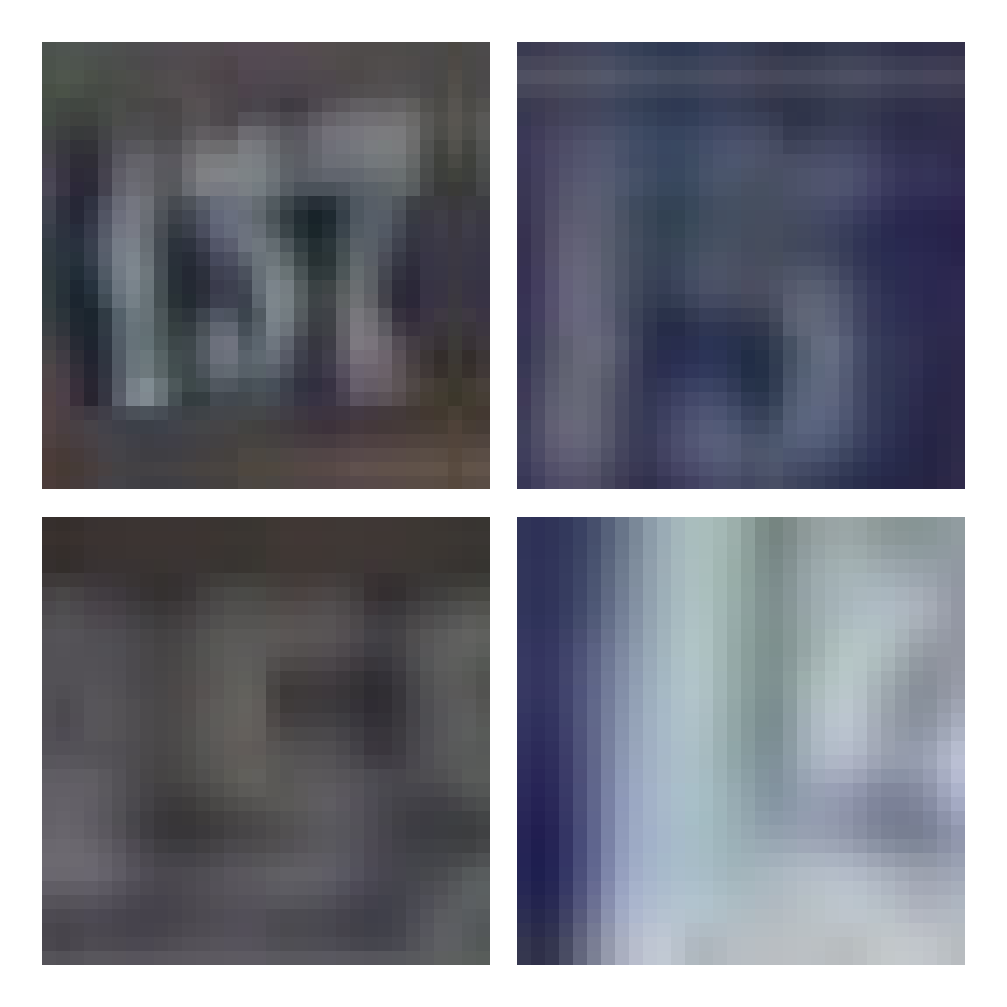

In [6]:
import random
from torchvision.utils import make_grid

n_plots=4
fig, ax = plt.subplots(figsize=(17,9))
t=torch.stack([svhn_train[random.randint(0, len(svhn_train)-1)][0] for i in range(n_plots)], dim=0)
grid = make_grid(t,
                  nrow=2, 
                  pad_value=1.)
    
ax.imshow(grid.permute(1, 2, 0).numpy())
ax.axis('off')

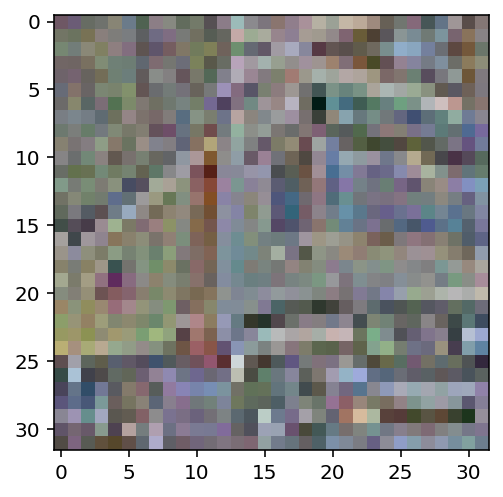

In [7]:
# CIFAR10
im_idx = 1
plt.imshow(cifar10_train[im_idx][0].permute(1, 2, 0)) 

(-0.5, 133.5, 133.5, -0.5)

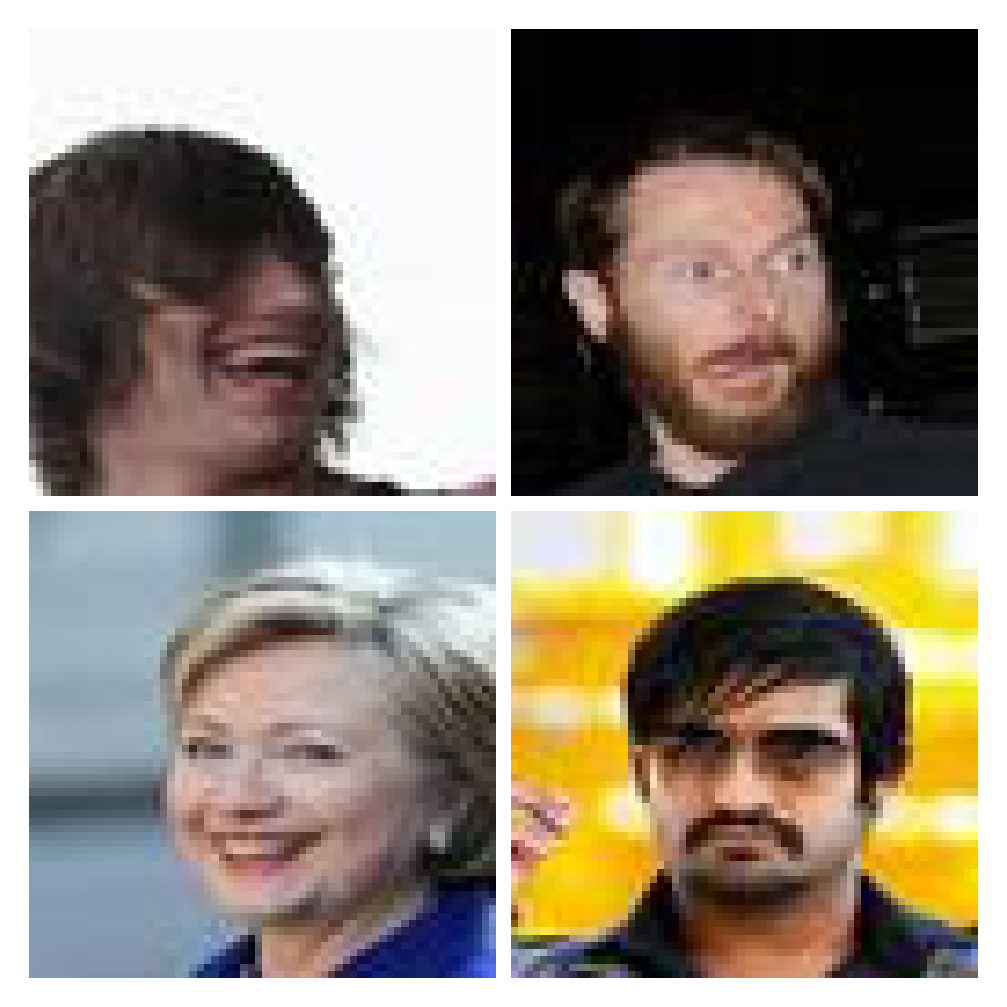

In [8]:
import random
from torchvision.utils import make_grid

n_plots=4
fig, ax = plt.subplots(figsize=(17,9))
t=torch.stack([celeba_train[random.randint(0, len(celeba_train)-1)][0] for i in range(n_plots)], dim=0)
grid = make_grid(t,
                  nrow=2, 
                  pad_value=1.)
    
ax.imshow(grid.permute(1, 2, 0).numpy())
ax.axis('off')

In [9]:
len(celeba_train)

182339

In [10]:
len(celeba_test)

20260

(-0.5, 69.5, 69.5, -0.5)

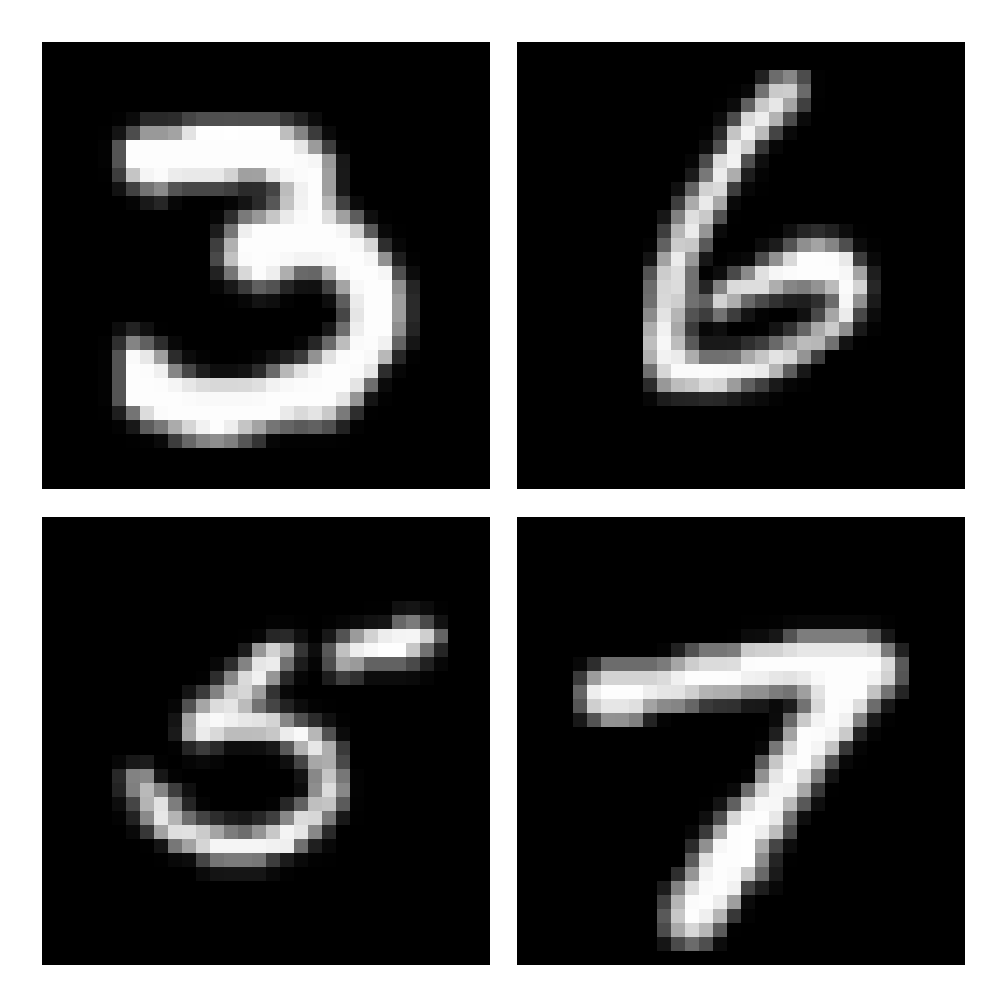

In [11]:
import random
from torchvision.utils import make_grid

n_plots=4
fig, ax = plt.subplots(figsize=(17,9))
t=torch.stack([mnist_train[random.randint(0, len(mnist_train)-1)][0] for i in range(n_plots)], dim=0)
grid = make_grid(t,
                  nrow=2, 
                  pad_value=1.)
    
ax.imshow(grid.permute(1, 2, 0).numpy())
ax.axis('off')

In [12]:
from skssl.transformers.neuralproc.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.50),
                                     target_masker=no_masker,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt_feat = GridCntxtTrgtGetter(context_masker=no_masker,
                                     target_masker=no_masker,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.50),
                                 target_masker=RandomMasker(min_nnz=0.50, max_nnz=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False, is_grided=False):
    def mycollate(batch):
        
        if isinstance(batch[0][0], dict):
            min_length = min([v.size(0) for b in batch for k,v in b[0].items() if "X" in k])
            # chose first min_legth of each (assumes that randomized)

            batch = [({k:v[:min_length, ...] for k,v in b[0].items()}, b[1]) for b in batch]        
            collated = torch.utils.data.dataloader.default_collate(batch)
        
            X = collated[0]["X"]
            y = collated[0]["y"]
        else:       
            collated = torch.utils.data.dataloader.default_collate(batch)
            
            X = collated[0]
            y = None
            collated[0] = dict()
        
        if is_repeat_batch:
            X = torch.cat([X,X], dim=0)
            if y is not None:
                y = torch.cat([y,y], dim=0)
            collated[1] = torch.cat([collated[1], collated[1]], dim=0) # targets
        
        if is_grided:
            collated = (dict(), collated[1])
            collated[0]["X"], collated[0]["mask_context"], collated[0]["mask_target"] = get_cntxt_trgt(X, y, 
                                                                                                       is_grided=True)
            
        else:
            collated[0]["X"], collated[0]["y"], collated[0]["X_trgt"], collated[0]["y_trgt"] = get_cntxt_trgt(X, y)
            
        
        return collated
    return mycollate

In [27]:
datasets = dict(svhn=(svhn_train, svhn_test), 
                #cifar10=(cifar10_train, cifar10_test), 
                celeba=(celeba_train, celeba_test),
                mnist=(mnist_train, mnist_test)
)

In [28]:
data_specific_kwargs = dict(svhn=dict(y_dim=svhn_train.shape[0]), 
                            #cifar10=dict(y_dim=cifar10_train.shape[0]), 
                            celeba=dict(y_dim=celeba_train.shape[0]),
                            mnist=dict(y_dim=mnist_train.shape[0]))

In [29]:
X_DIM = 2  # 2D spatial input 
#Y_DIM = data.shape[0]
N_TARGETS = None#data.n_classes

#label_percentages = [N_TARGETS, N_TARGETS*2, 0.01, 0.05, 0.1, 0.3, 0.5, 1]

# Model

In [30]:
from skssl.transformers import AttentiveNeuralProcess, NeuralProcessLoss, GridConvNeuralProcess, GridNeuralProcessLoss
from skssl.predefined import UnetCNN, CNN, SelfAttention, MLP, SelfAttention, SinusoidalEncodings, merge_flat_input
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split

models_general = {}
models_grided = {}

anp_kwargs = dict(r_dim=128, 
                  get_cntxt_trgt=precomputed_cntxt_trgt_split,
                  attention="transformer",
                  encoded_path="deterministic",
                  XYEncoder=merge_flat_input(SelfAttention, is_sum_merge=True),
                  output_range=(0,1))


unet = partial(UnetCNN,
               Conv=torch.nn.Conv2d,
               Pool=torch.nn.MaxPool2d,
               upsample_mode="bilinear",
               n_layers=14,
               is_double_conv=True,
               is_depth_separable=True,
               Normalization=torch.nn.BatchNorm2d,
               is_chan_last=True,
               bottleneck=None,
               kernel_size=7,
               max_nchannels=256,
               is_force_same_bottleneck=True,
               _is_summary=True,
              )

cnn = partial(CNN,
                  Conv=torch.nn.Conv2d,
                  n_layers=5,
                  is_depth_separable=True,
                  Normalization=torch.nn.BatchNorm2d,
                  is_chan_last=True,
                  kernel_size=11
                  )


gnp_kwargs = dict(r_dim=32,
                  output_range=(0,1),
                  is_normalize=True,
                  TmpSelfAttn=unet)

gnp_large_kwargs = dict(r_dim=64,
                  output_range=(0,1),
                  is_normalize=True,
                  TmpSelfAttn=partial(unet, n_layers=18))

gnp_simple_kwargs = dict(r_dim=256,
                             output_range=(0, 1),
                             is_normalize=True,
                             TmpSelfAttn=cnn)

# initialize one model for each dataset
models_general["anp_simple"] = partial(AttentiveNeuralProcess, x_dim=X_DIM, **anp_kwargs)
#models_grided["transformer_gnp_unet"] = partial(GridConvNeuralProcess, **gnp_kwargs)
models_grided["transformer_gnp_large_unet"] = partial(GridConvNeuralProcess, **gnp_large_kwargs)
models_grided["extended_gnp_simple"] = partial(GridConvNeuralProcess,
                                                   **gnp_simple_kwargs)

In [31]:
from utils.helpers import count_parameters
for k,v in models_general.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))
    
for k,v in models_grided.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))

anp_simple - N Param: 314150
transformer_gnp_large_unet - N Param: 1188615
extended_gnp_simple - N Param: 404615


# Training

In [32]:
N_EPOCHS = 100 
BATCH_SIZE = 32
IS_RETRAIN = False # if false load precomputed
chckpnt_dirname="results/notebooks/neural_process_images/"

from ntbks_helpers import train_models_

In [33]:
data_trainers_grided = {}
data_trainers_grided.update(train_models_(datasets,#{k:v for k,v in datasets.items() if k =="celeba"}, 
                       models_grided, # #
                        GridNeuralProcessLoss,
                      data_specific_kwargs=data_specific_kwargs,
                     patience=15,
                     chckpnt_dirname=chckpnt_dirname,
                      max_epochs=N_EPOCHS,
                      batch_size=BATCH_SIZE,
                      is_retrain=IS_RETRAIN,
                      callbacks=[],
                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_grided=True, is_repeat_batch=True),  
                      iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_test, is_grided=True),
                      mode="transformer"))


--- Loading svhn/transformer_gnp_large_unet ---

svhn/transformer_gnp_large_unet best epoch: 6 val_loss: -3.949710527958134

--- Loading svhn/extended_gnp_simple ---

svhn/extended_gnp_simple best epoch: 24 val_loss: -3.9767382102431736

--- Loading celeba/transformer_gnp_large_unet ---

celeba/transformer_gnp_large_unet best epoch: 5 val_loss: -3.655739565074503

--- Loading celeba/extended_gnp_simple ---

celeba/extended_gnp_simple best epoch: 13 val_loss: -3.6855636422043374

--- Loading mnist/transformer_gnp_large_unet ---

mnist/transformer_gnp_large_unet best epoch: 9 val_loss: -1.2522213287353516

--- Loading mnist/extended_gnp_simple ---

mnist/extended_gnp_simple best epoch: 14 val_loss: -1.2747274236679078


In [20]:
data_trainers_general = train_models_({k:v for k,v in datasets.items() if k in ["mnist", "svhn"]}, 
                      models_general,
                      NeuralProcessLoss,
                      data_specific_kwargs=data_specific_kwargs,
                      patience=15,
                      chckpnt_dirname= chckpnt_dirname,
                      max_epochs=N_EPOCHS,
                      batch_size=BATCH_SIZE,
                      is_retrain=IS_RETRAIN,
                      callbacks=[],
                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
                      iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_test),
                      mode="transformer")


--- Loading svhn/anp_simple ---

svhn/anp_simple best epoch: 8 val_loss: -3.9245849417702288

--- Loading mnist/anp_simple ---

mnist/anp_simple best epoch: 1 val_loss: -0.976733584690094


* debug and test gnp
* make all for SSL

In [34]:
from skssl.utils.helpers import prod

def idcs_grid_to_idcs_flatten(idcs, grid_shape):
    """Convert a tensor containing indices of a grid to indices on the flatten grid."""
    for i, size in enumerate(grid_shape):
        idcs[:, :, i] *= prod(grid_shape[i+1:]) 
    return idcs.sum(-1)

def points_to_grid(X, Y, grid_shape, background=torch.tensor([0., 0., 0.])):
    """Converts points to a grid (undo mask select from datasplit)"""
    
    batch_size, _, y_dim = Y.shape
    X = X.clone()
    background = background.view(1, *(1 for _ in grid_shape), y_dim).repeat(batch_size, *grid_shape, 1)
    
    for i, size in enumerate(grid_shape):
        X[:, :, i] += 1  # in [0,2]
        X[:, :, i] /= 2 / (size - 1)  # in [0,size]
    
    X = X.long()
    X = idcs_grid_to_idcs_flatten(X, grid_shape)
    
    background = background.view(batch_size, -1, y_dim)

    for b in range(batch_size):
        background[b,X[b],:] = Y[b]

    background = background.view(batch_size, *grid_shape, y_dim)
    
    return background

In [35]:
from ntbks_viz import _get_p_y_pred
from torchvision.utils import make_grid
import random

def plot_predictions_img_grid(data, get_cntxt_trgt, model, mod_comp=None, n_plots=4, figsize=(18, 4), ax=None):
    
    model.eval()
    cntxt_trgt = cntxt_trgt_collate(get_cntxt_trgt, is_grided=True)(
        [data[random.randint(0,len(data))] for _ in range(n_plots)])[0]
    X, mask_cntxt, mask_trgt = cntxt_trgt["X"], cntxt_trgt["mask_context"].unsqueeze(1), cntxt_trgt["mask_target"].unsqueeze(1)
    p_y_pred, *_ = model(**cntxt_trgt)
    print(p_y_pred.base_dist.scale.detach().min(), p_y_pred.base_dist.scale.detach().mean())
    mean_y = p_y_pred.base_dist.loc.detach()
    
    if mod_comp is not None:
        mod_comp.eval()
        p_y_pred_comp = _get_p_y_pred(mod_comp, X_cntxt, Y_cntxt, X_trgt)
        mean_y_comp = p_y_pred_comp.base_dist.loc.detach()
        
    
    if X.shape[1] == 1:
        background = torch.tensor([0., 0., 1.]) # blue
        X = X.expand(-1, 3, -1, -1)
        mean_y = mean_y.expand(-1, -1, 3)
        
        if mod_comp is not None:
            mean_y_comp = mean_y_comp.expand(-1, -1, 3)
        
    else:
        background = torch.tensor([0., 0., 0.]) # black
 
    background = background.view(1, 3, 1, 1).expand(*X.shape).clone()
    out_cntxt = torch.where(mask_cntxt, X, background)
    
    background.permute(0,2,3,1)[mask_trgt.squeeze(1)] = mean_y.view(-1,3)
    #background.masked_scatter(mask_trgt, mean_y)
    out_pred = background.clone()
    
    outs = [out_cntxt, out_pred.clone()]
    
    if mod_comp is not None:
            
        background.masked_scatter(mask_trgt, mean_y_comp)
        out_comp = background.clone()
        outs.append(out_comp)

    grid = make_grid(torch.cat(outs, dim=0),
                      nrow=n_plots, 
                      pad_value=1.)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(grid.permute(1, 2, 0).numpy(), )
    ax.axis('off')
    
    return grid
    
def plot_predictions_img_general(data, get_cntxt_trgt, model, mod_comp=None, n_plots=4, figsize=(18, 4), ax=None):
    model.eval()
    
    cntxt_trgt = cntxt_trgt_collate(get_cntxt_trgt)([data[random.randint(0,len(data))] for _ in range(n_plots)])[0]
    X_cntxt, Y_cntxt, X_trgt, Y_trgt = cntxt_trgt["X"], cntxt_trgt["y"], cntxt_trgt["X_trgt"], cntxt_trgt["y_trgt"]
    p_y_pred, *_ = model.forward_step(X_cntxt, Y_cntxt, X_trgt)
    mean_y = p_y_pred.base_dist.loc.detach()
    
    if mod_comp is not None:
        mod_comp.eval()
        p_y_pred_comp, *_ = mod_comp.forward_step(X_cntxt, Y_cntxt, X_trgt)
        mean_y_comp = p_y_pred_comp.base_dist.loc.detach()
        
    
    if Y_cntxt.shape[-1] == 1:
        background = torch.tensor([0., 0., 1.]) # blue
        Y_cntxt = Y_cntxt.expand(-1, -1, 3)
        mean_y = mean_y.expand(-1, -1, 3)
        
        if mod_comp is not None:
            mean_y_comp = mean_y_comp.expand(-1, -1, 3)
        
    else:
        background = torch.tensor([0., 0., 0.]) # black
 
    out_cntxt = points_to_grid(X_cntxt, 
                         Y_cntxt, 
                         data.shape[1:], 
                         background=background)
    
    out_pred = points_to_grid(X_trgt, 
                         mean_y, 
                         data.shape[1:], 
                         background=background)
    
    outs = [out_cntxt, out_pred]
    
    if mod_comp is not None:
            
        outs.append(points_to_grid(X_trgt, 
                         mean_y_comp, 
                         data.shape[1:], 
                         background=background))

    grid = make_grid(torch.cat(outs, dim=0).permute(0, 3, 1, 2),
                      nrow=n_plots, 
                      pad_value=1.)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(grid.permute(1, 2, 0).numpy())
    ax.axis('off')
    
    return grid

tensor(0.1000) tensor(0.1086)
tensor(0.1000) tensor(0.1372)
tensor(0.1000) tensor(0.1111)
tensor(0.1000) tensor(0.1077)
tensor(0.1000) tensor(0.1016)
tensor(0.1000) tensor(0.1000)


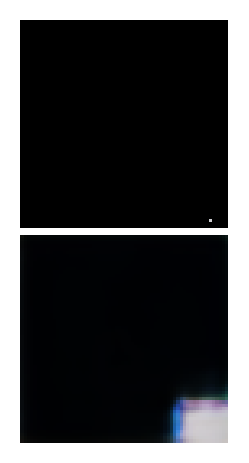

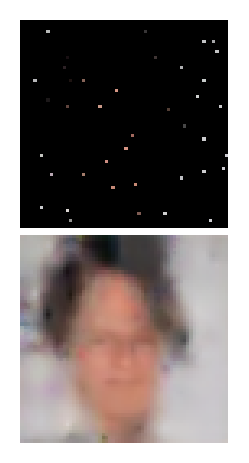

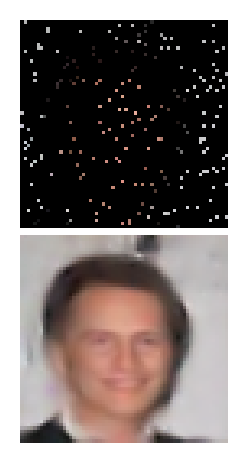

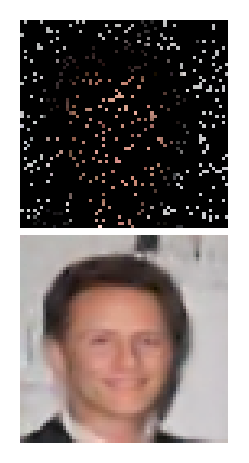

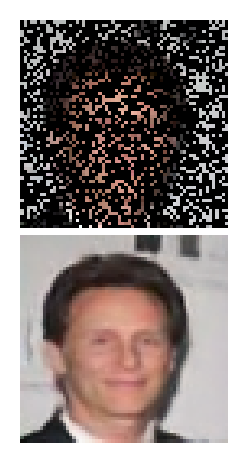

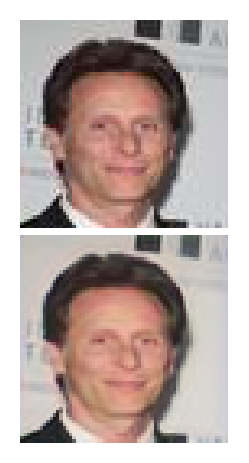

In [21]:

grids = []
n_indcs = [1e-10, 1, 5, 10,30,100 ]

seed=1

for i, n_indc in enumerate(n_indcs):
    for data_name, (data_train, data_test) in datasets.items():
        if data_name != "celeba": 
            continue
            
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        grids.append(plot_predictions_img_grid(data_test, 
                              GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=n_indc/100, max_nnz=n_indc/100),
                                                 target_masker=no_masker,
                                                 is_add_cntxts_to_trgts=False), 
                              data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                              n_plots=1))

(-0.5, 407.5, 133.5, -0.5)

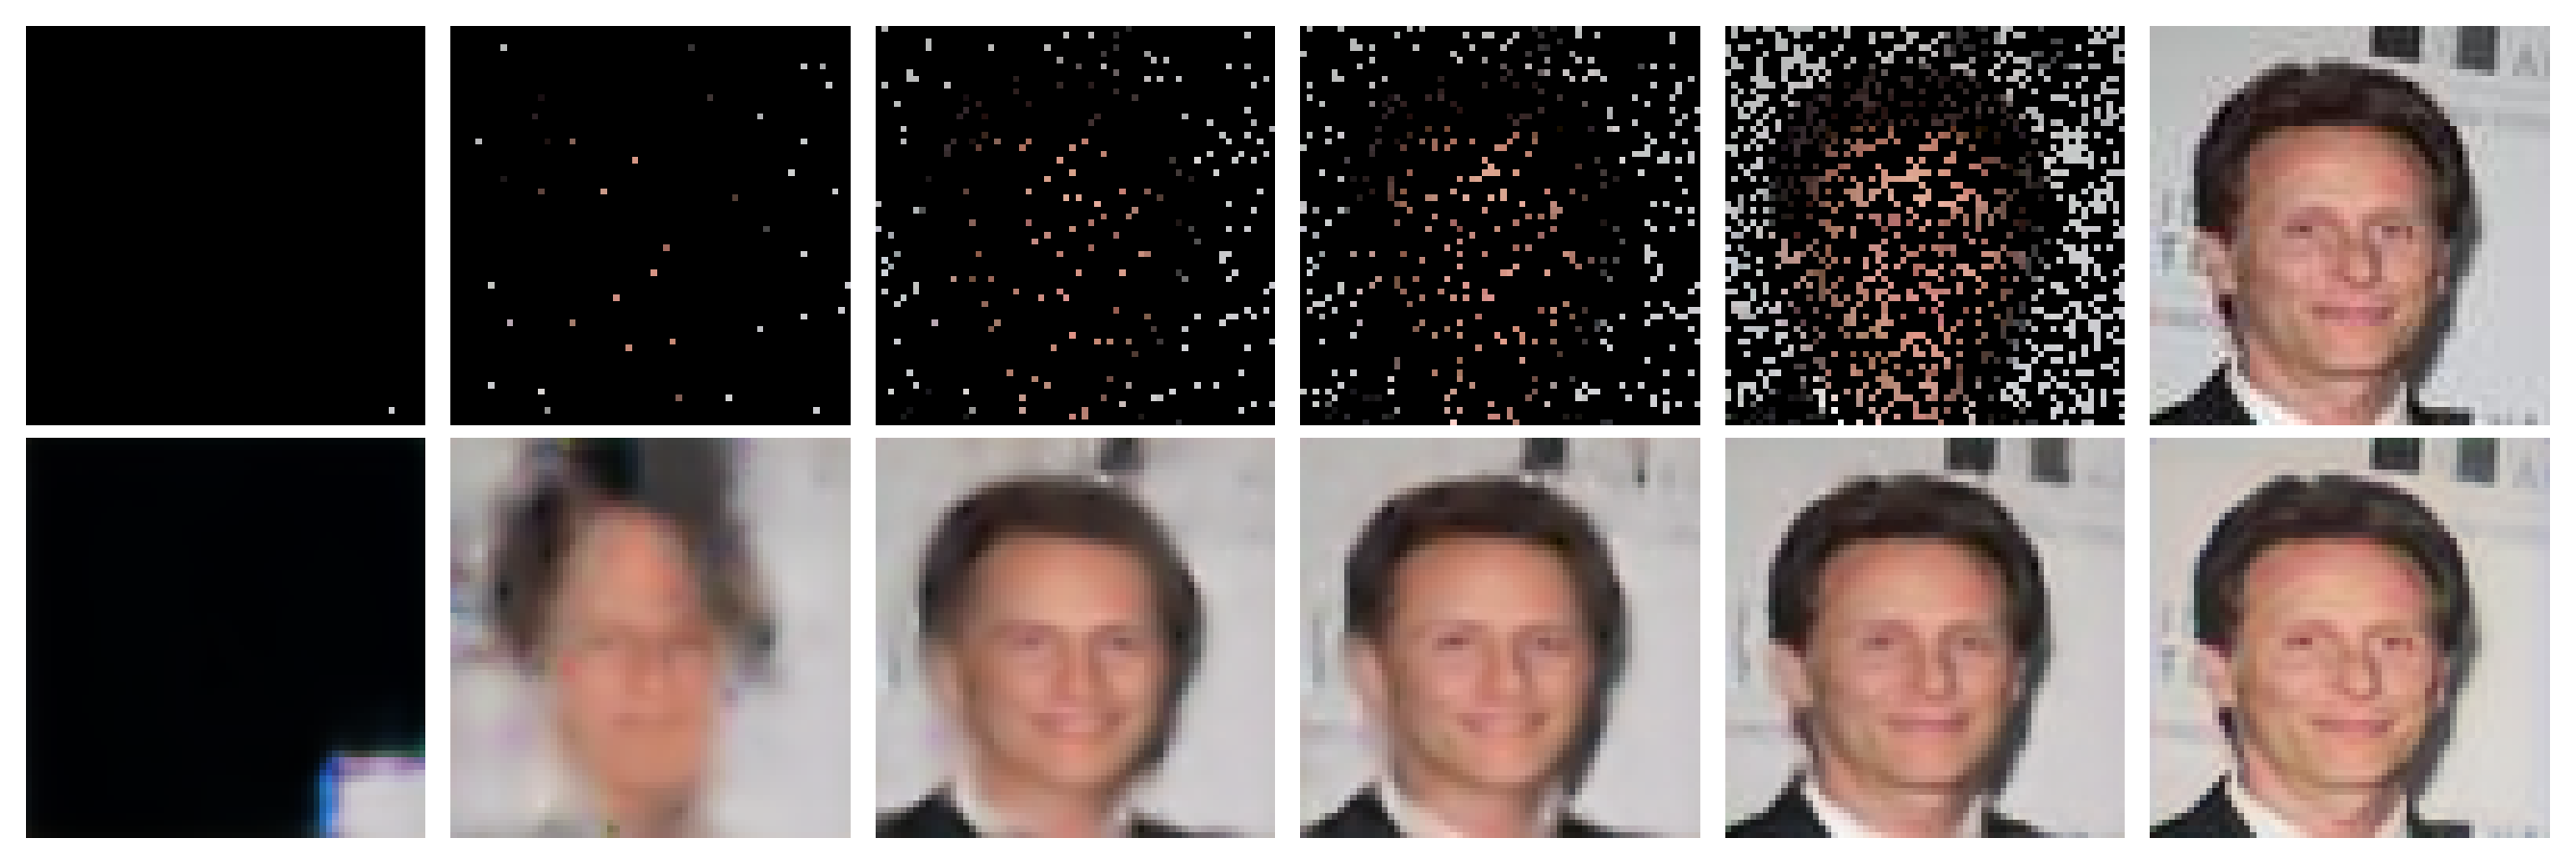

In [25]:
fig, ax = plt.subplots(figsize=(32, 8))
grid=torch.cat(grids, dim=2)
ax.imshow(grid.permute(1, 2, 0).numpy())
ax.axis('off')

In [21]:
# 'train_loss': -1.259864202817281,
# 'valid_loss': -1.2522213287353516,
# nearly same

In [36]:
datasets.keys()

dict_keys(['svhn', 'cifar10', 'celeba', 'mnist'])

tensor(0.1000) tensor(0.1000)
tensor(0.1000) tensor(0.1021)
tensor(0.1000) tensor(0.1031)


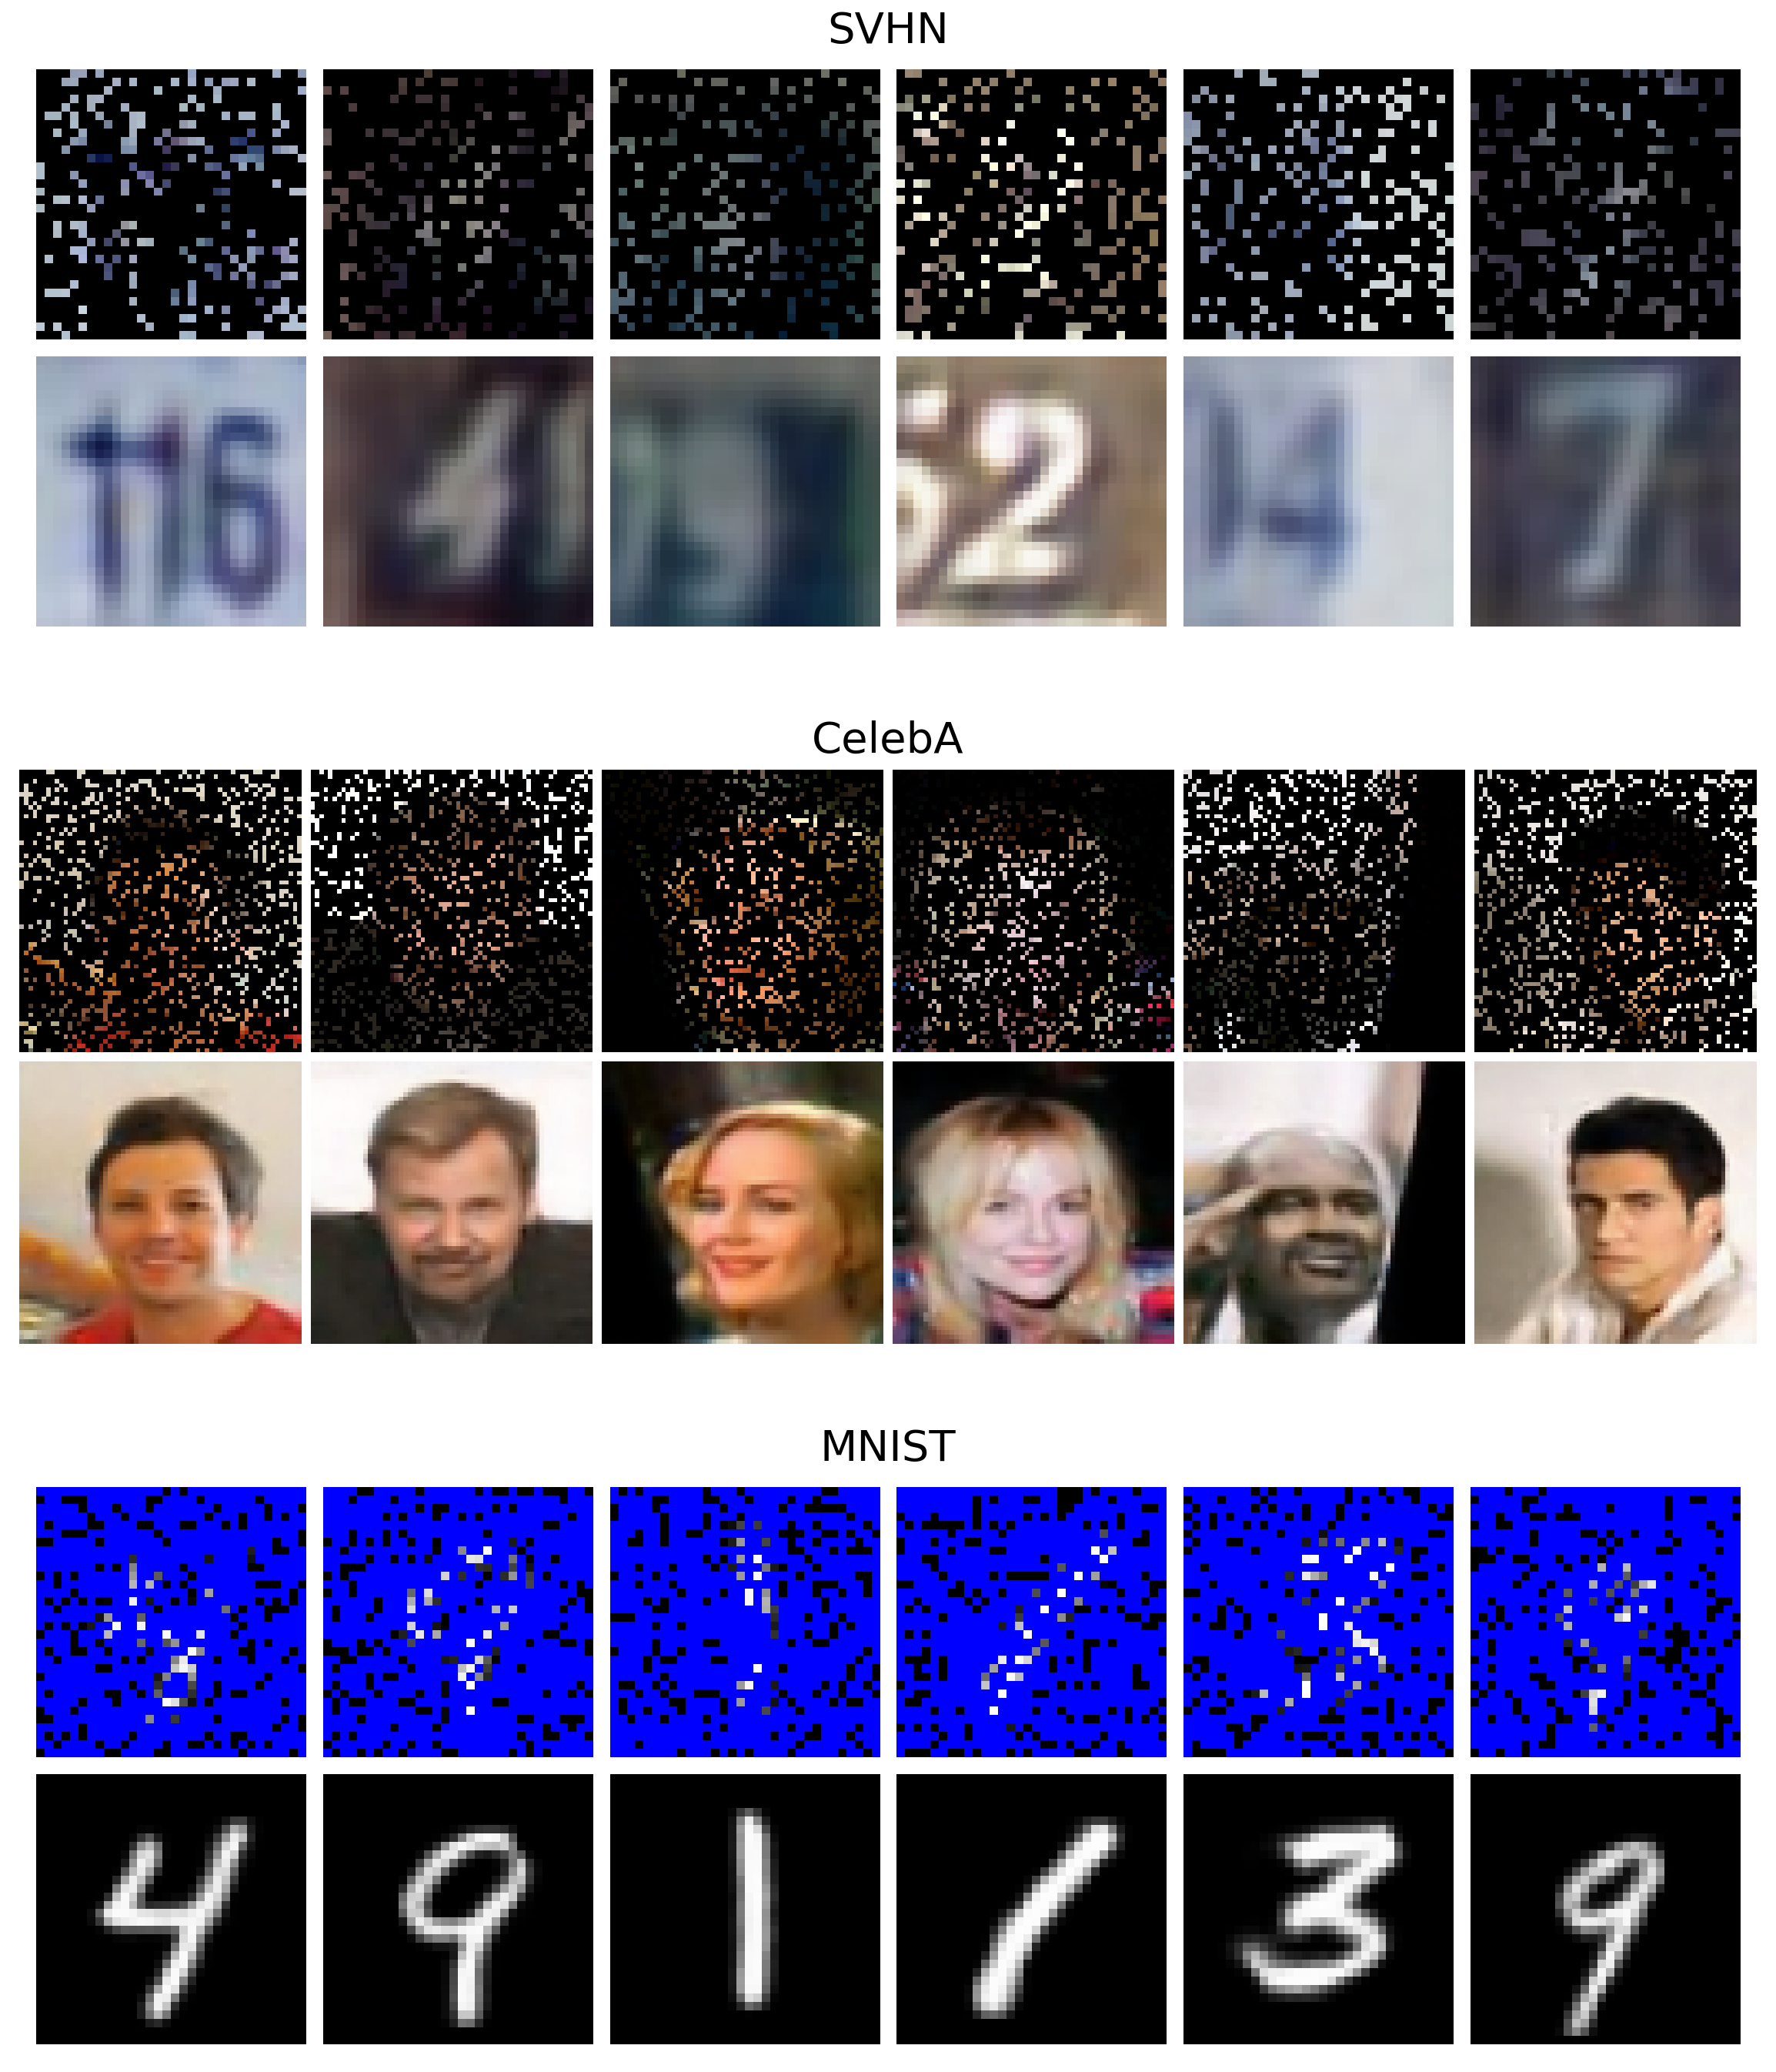

In [22]:

fig, axes = plt.subplots(3,1, figsize=(24, 24))

dataset_names = {"mnist": "MNIST", "svhn": "SVHN", "celeba": "CelebA"}

i = 0
for data_name, (data_train, data_test) in datasets.items():
    if data_name == "cifar10": 
        continue
        
    
    plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=6,
                          figsize=(18, 8),
                             ax=axes[i])
    
    axes[i].set_title(dataset_names[data_name], fontsize=28)
    
    i += 1

tensor(0.1000) tensor(0.1000)


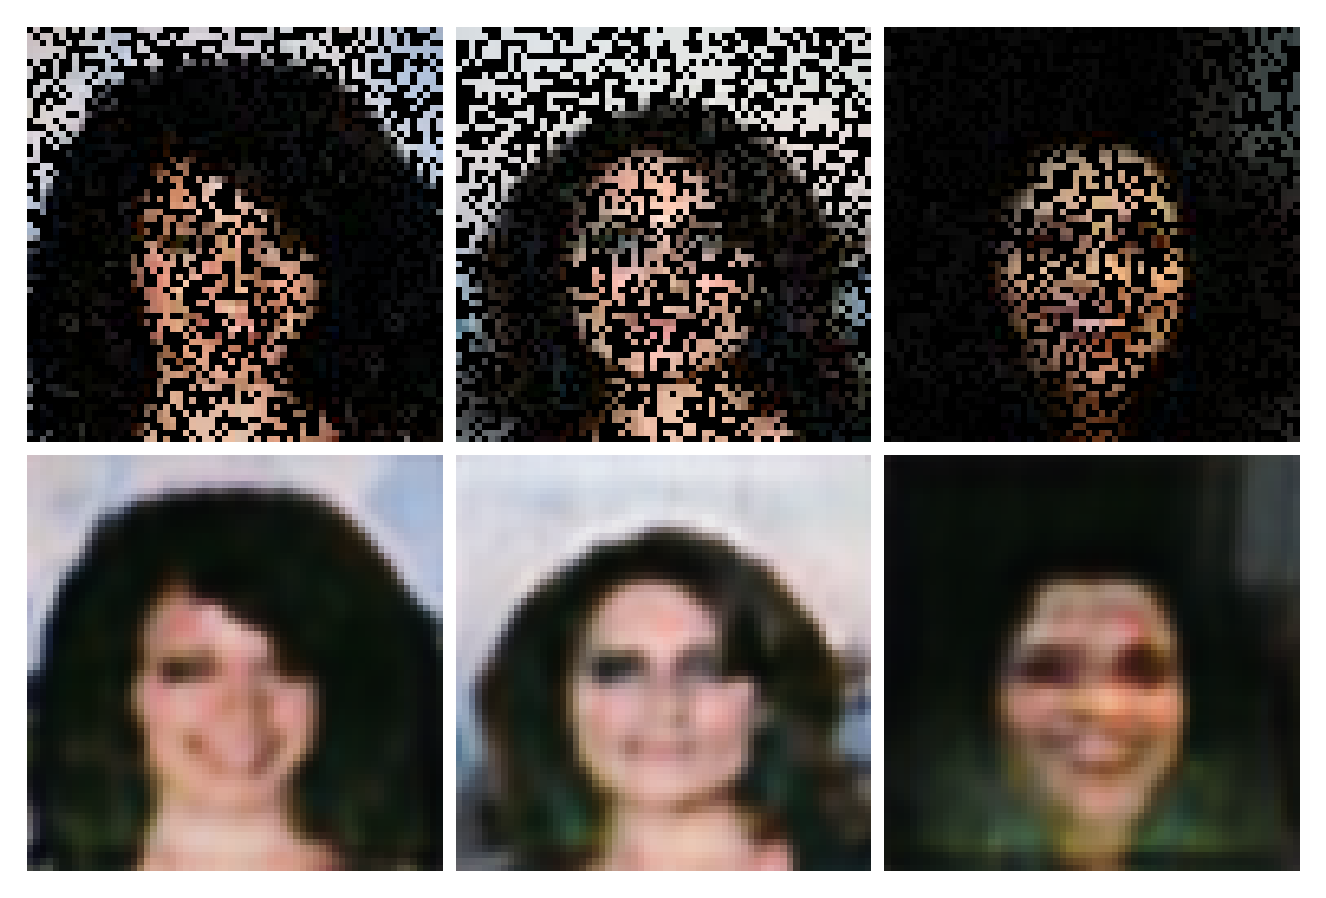

In [29]:
for data_name, (data_train, data_test) in datasets.items():
    if data_name != "celeba": 
        continue
    plot_predictions_img_grid(data_train, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.5, max_nnz=.5),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided["svhn"+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=3,
                          figsize=(18, 8))

tensor(0.1000) tensor(0.1000)


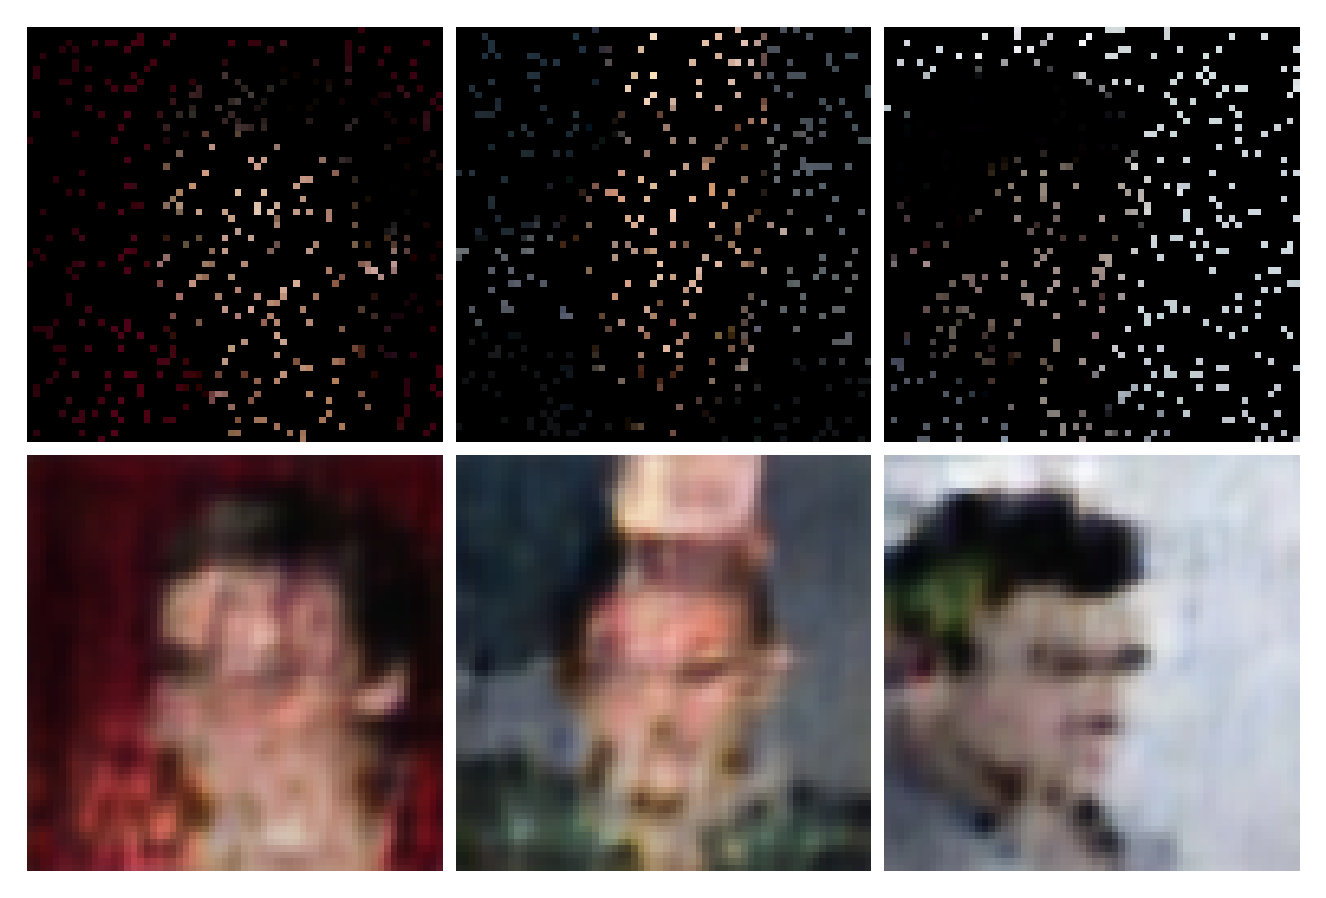

In [33]:
for data_name, (data_train, data_test) in datasets.items():
    if data_name != "celeba": 
        continue
    plot_predictions_img_grid(data_train, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided["svhn"+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=3,
                          figsize=(18, 8))

tensor(0.1000) tensor(0.1087)


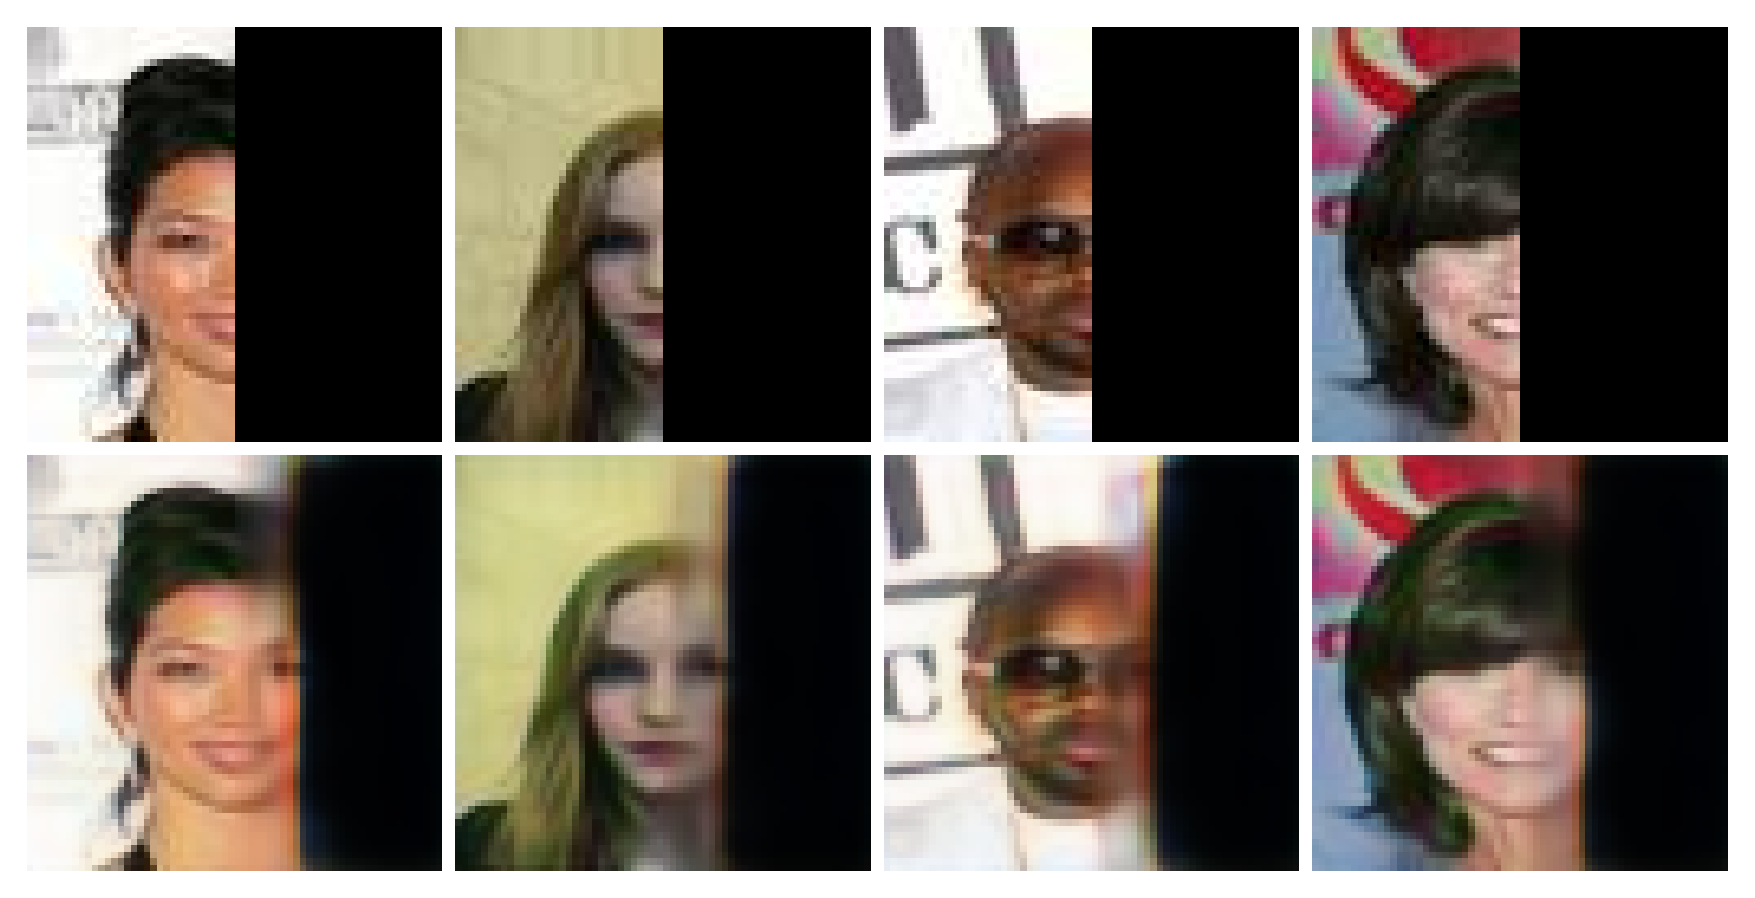

In [48]:
seed = 5

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
        
for data_name, (data_train, data_test) in datasets.items():
    if data_name != "celeba": 
        continue
    plot_predictions_img_grid(data_train, 
                          GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 8))

tensor(0.1000) tensor(0.1000)
tensor(0.1000) tensor(0.1529)
tensor(0.1000) tensor(0.1097)
tensor(0.1000) tensor(0.1259)


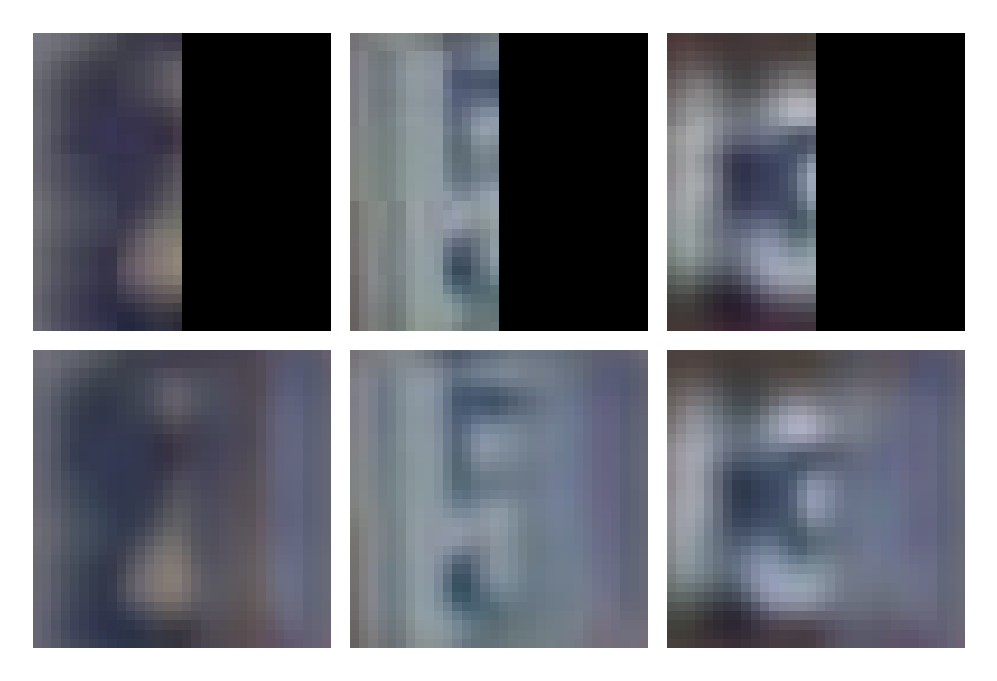

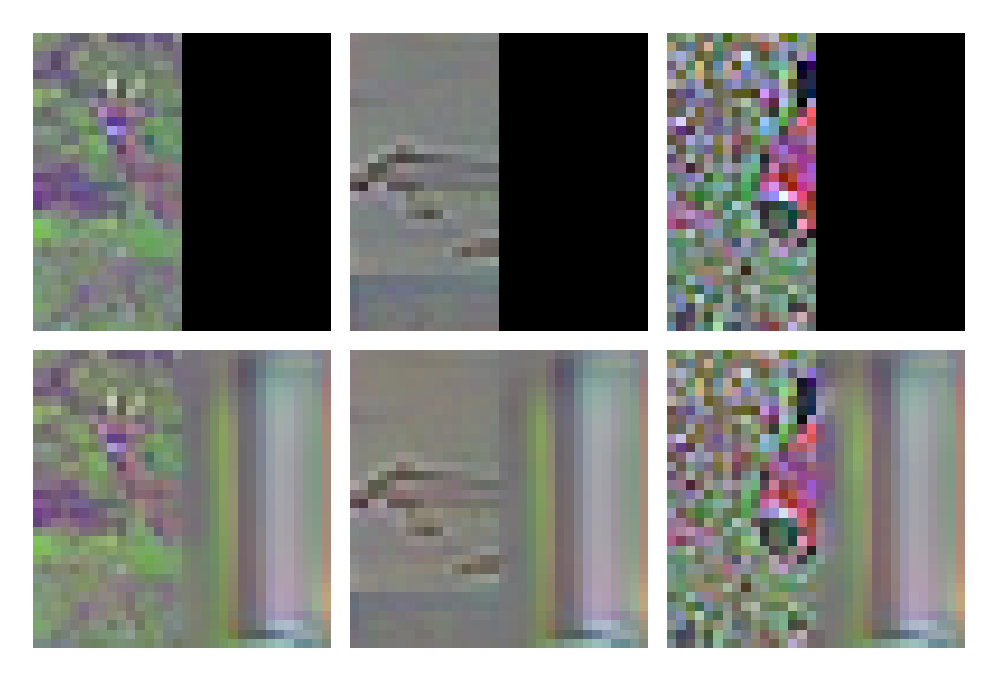

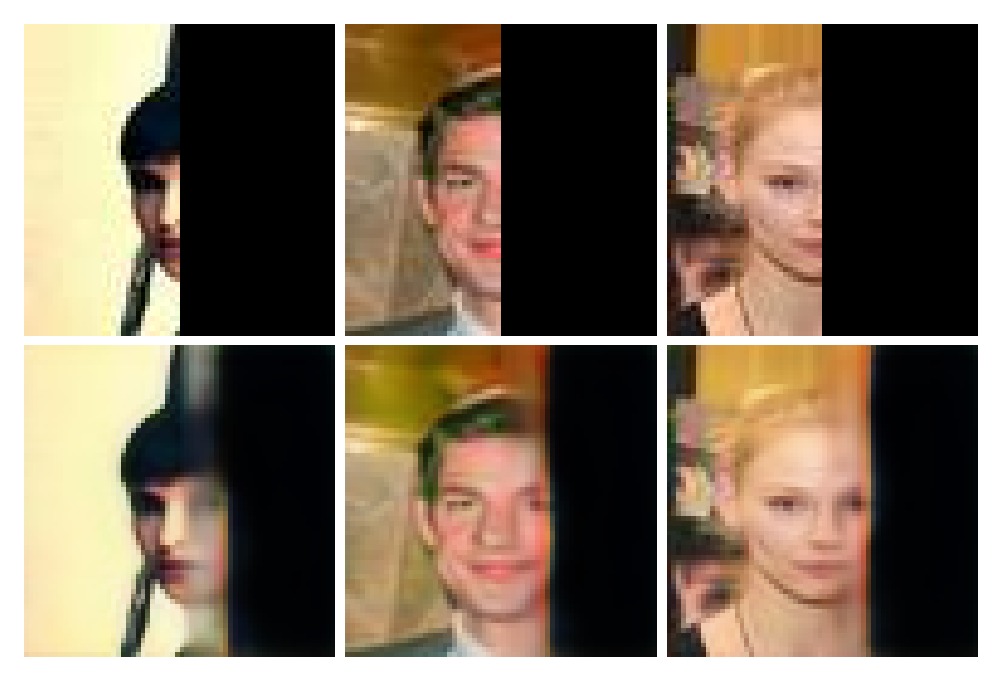

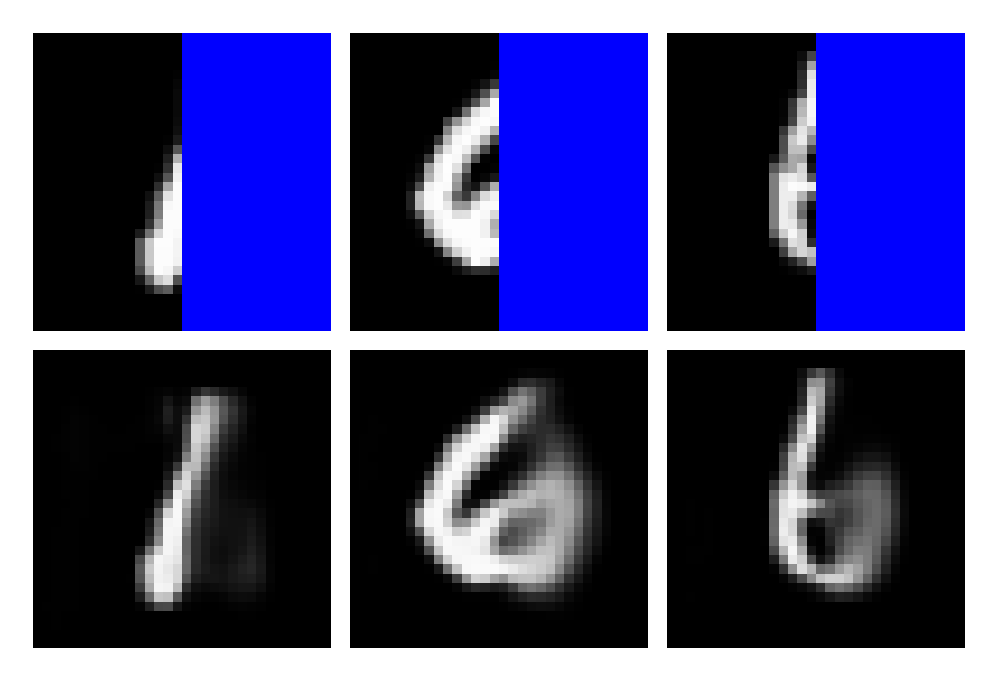

In [63]:
for data_name, (data_train, data_test) in datasets.items():
    #if data_name != "celeba": continue
    plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=3,
                          figsize=(18, 6))

tensor(0.1000) tensor(0.1000)
tensor(0.1000) tensor(0.1001)
tensor(0.1000) tensor(0.1000)
tensor(0.1000) tensor(0.1002)


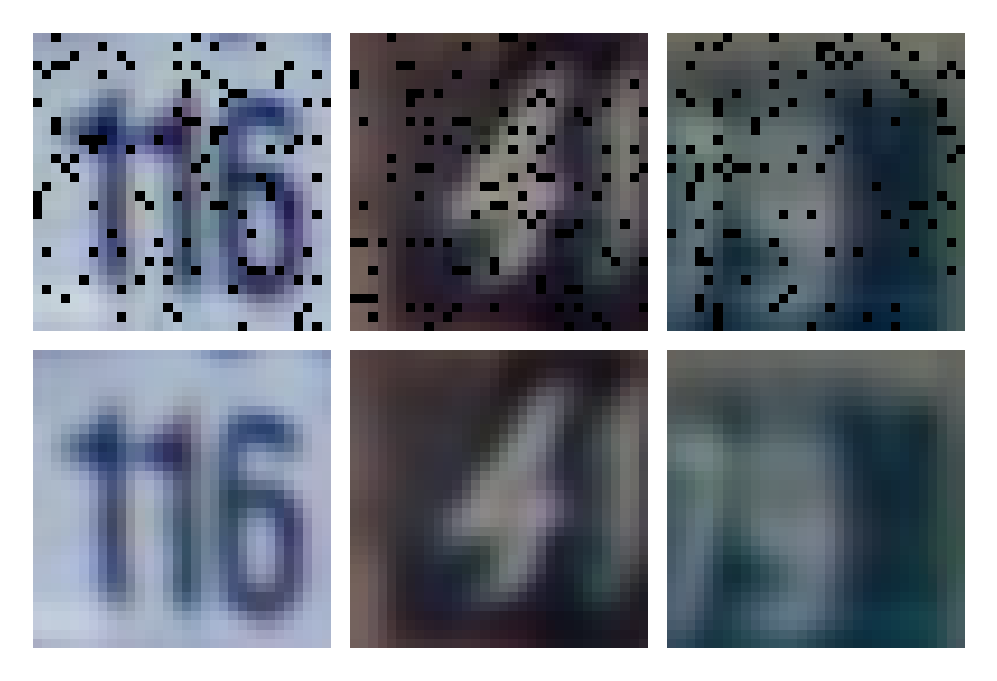

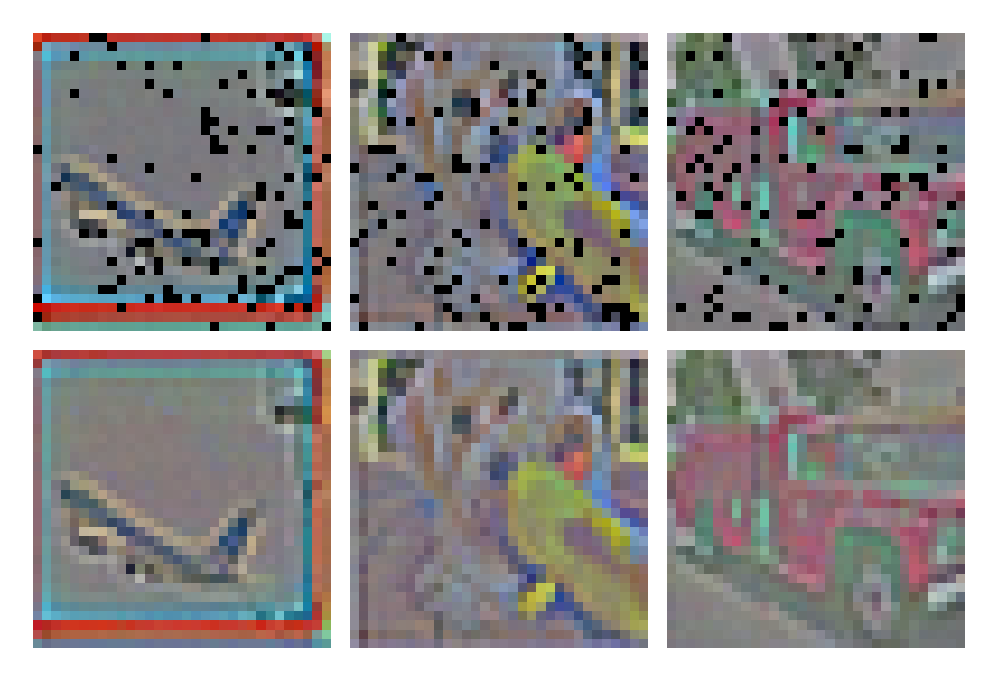

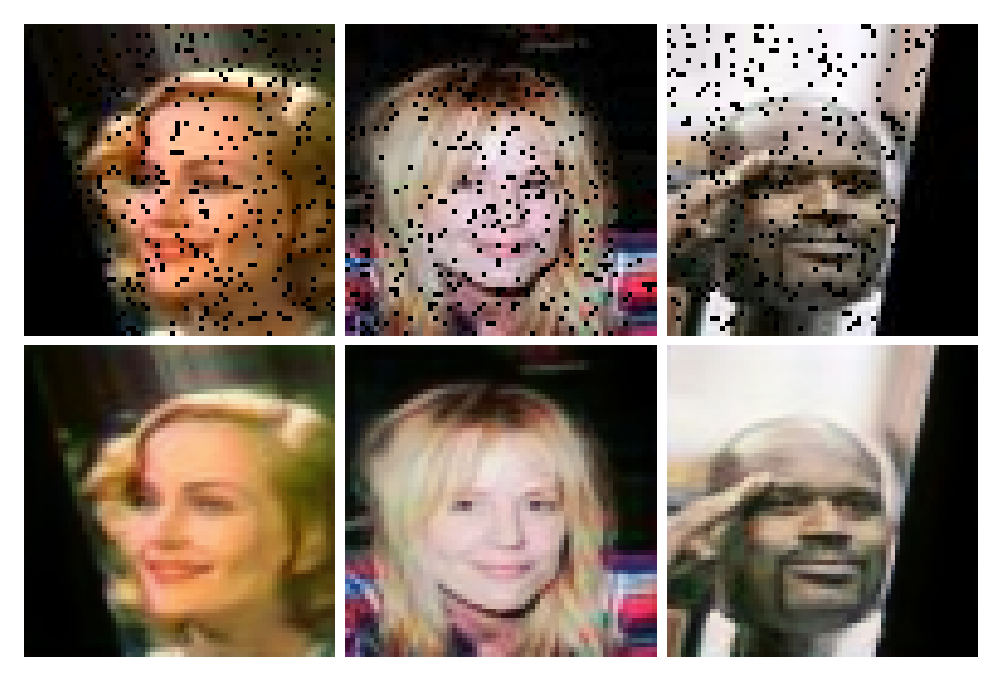

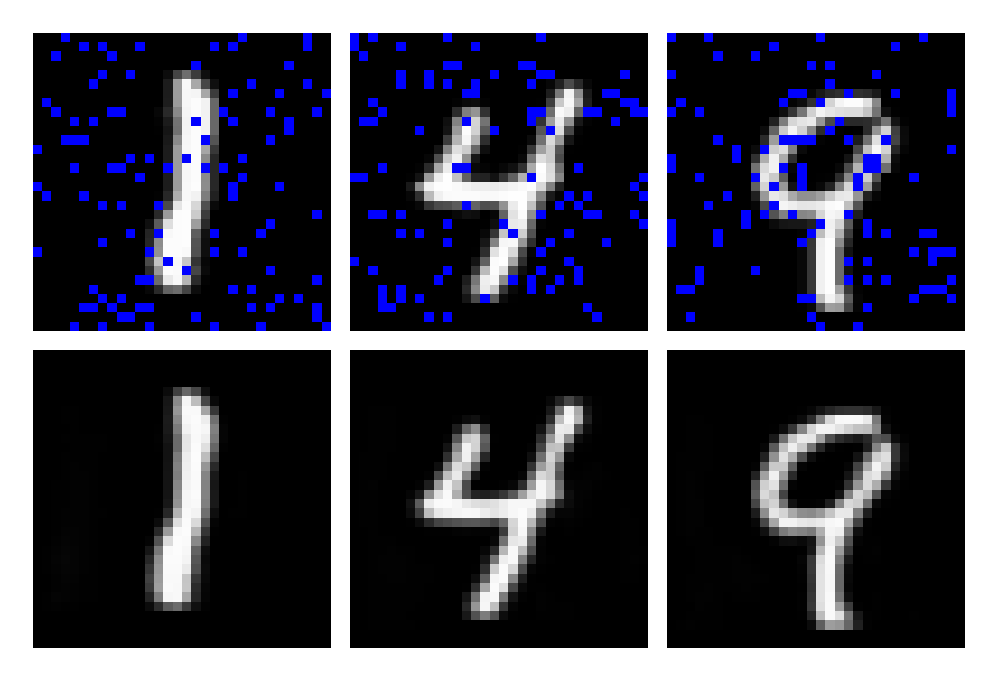

In [22]:
for data_name, (data_train, data_test) in datasets.items():
    #if data_name != "celeba": continue
    plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.9, max_nnz=.9),#partial(half_masker, dim=1)
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=3,
                          figsize=(18, 6))

tensor(0.1000) tensor(0.1000)
tensor(0.1000) tensor(0.1504)
tensor(0.1000) tensor(0.1116)
tensor(0.1000) tensor(0.1328)


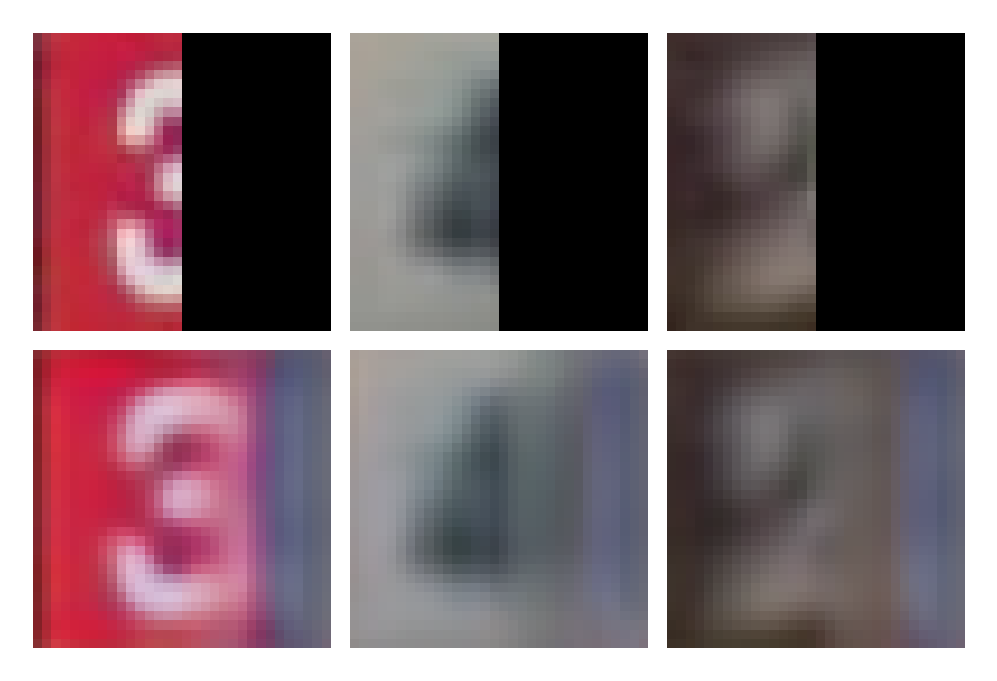

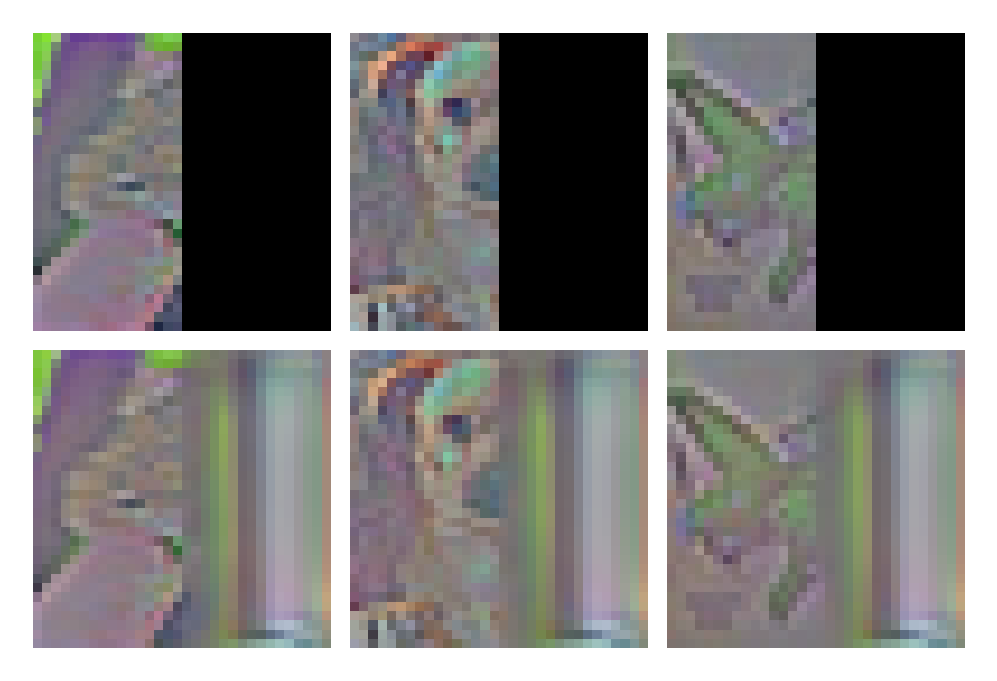

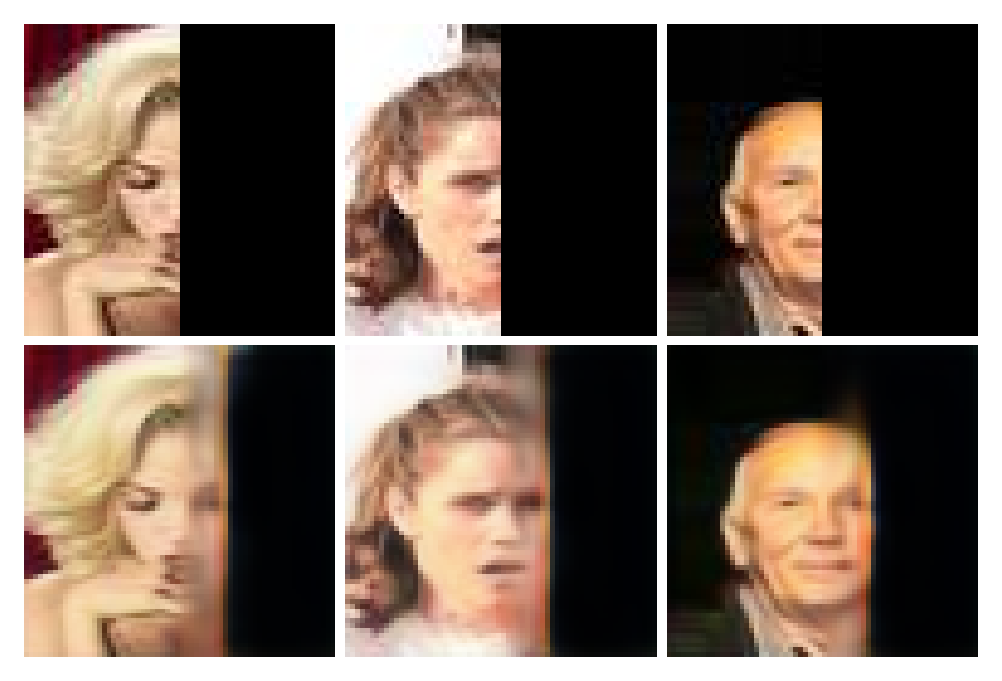

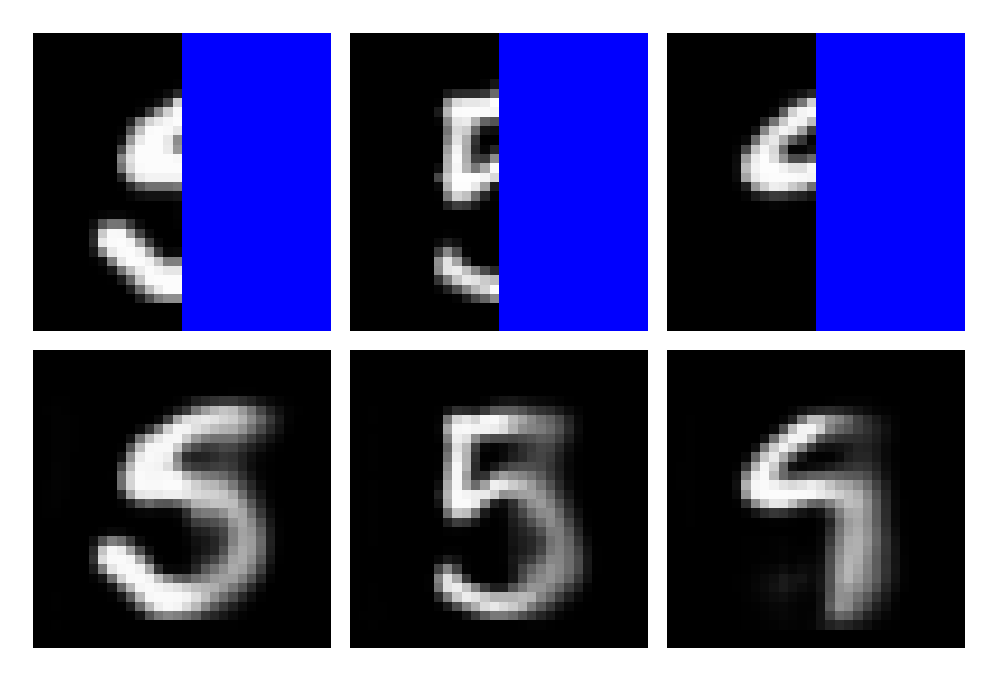

In [23]:
for data_name, (data_train, data_test) in datasets.items():
    #if data_name != "celeba": continue
    plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=3,
                          figsize=(18, 6))

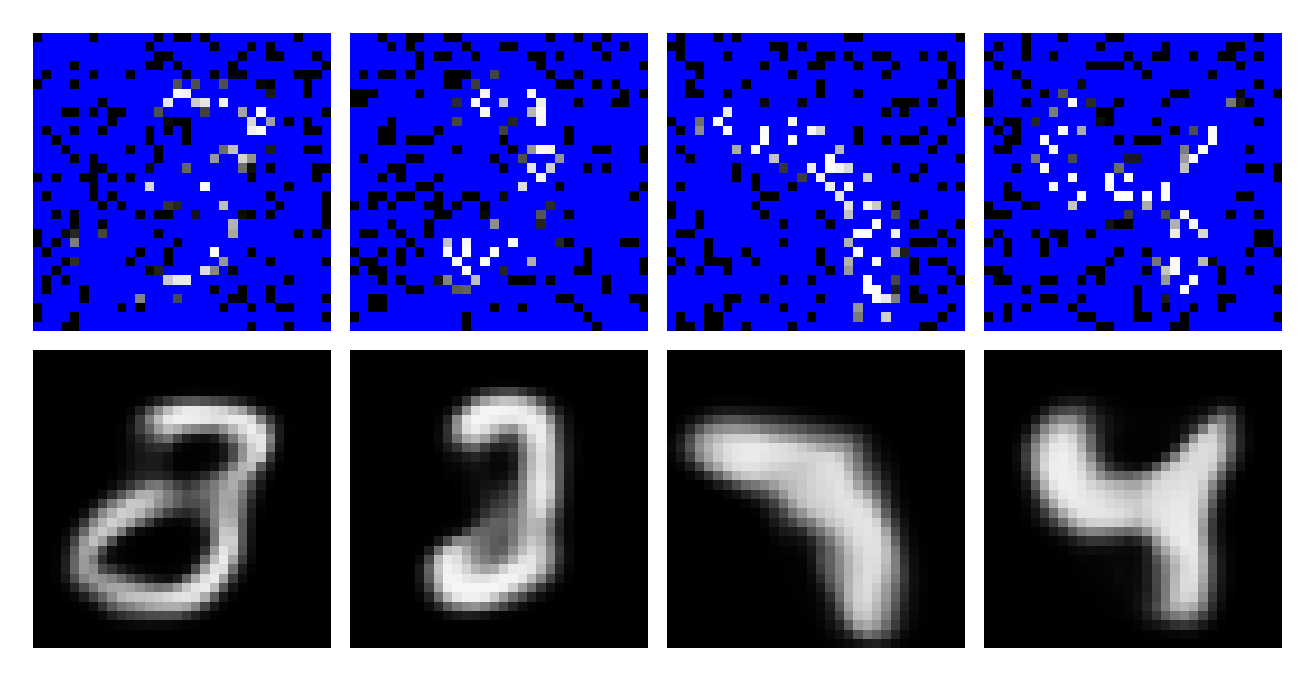

In [24]:
for data_name, (data_train, data_test) in datasets.items():
    if data_name != "mnist":
        continue
    plot_predictions_img_general(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2),#partial(half_masker, dim=1), #
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_general[data_name+"/"+"anp_simple"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))

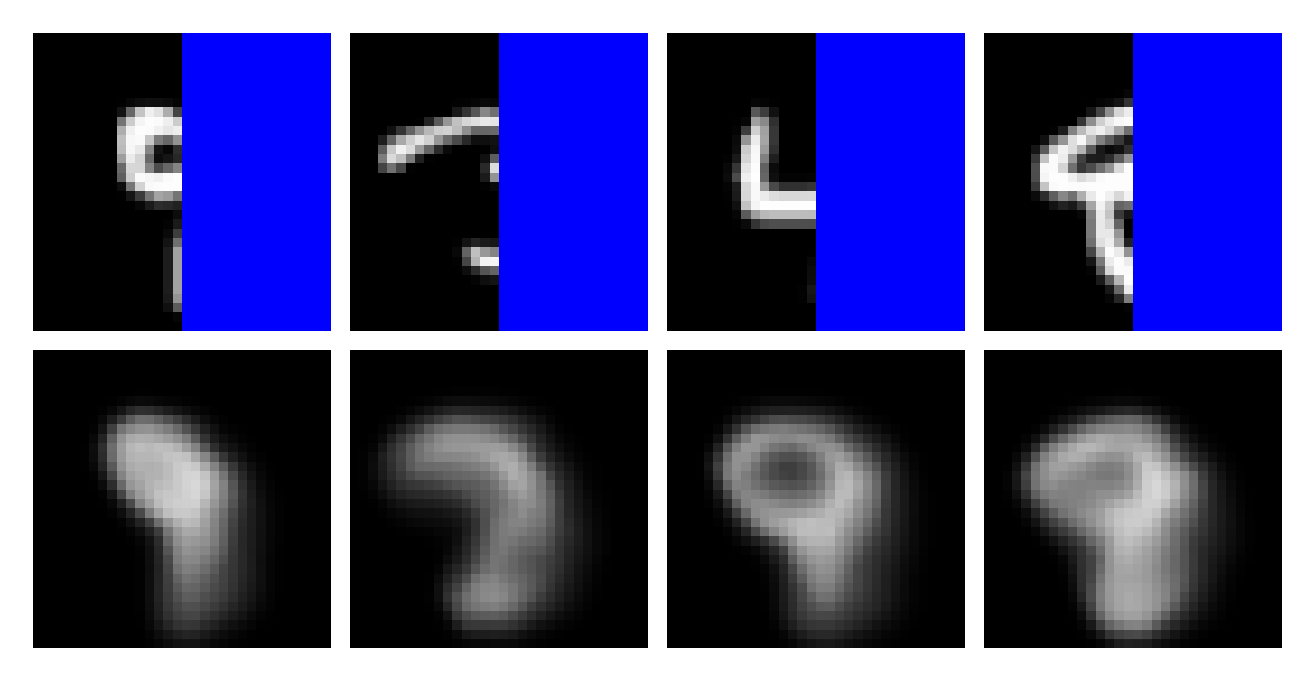

In [32]:
for data_name, (data_train, data_test) in datasets.items():
    if data_name != "mnist":
        continue
    plot_predictions_img_general(data_test, 
                          GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), #
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_general[data_name+"/"+"anp_simple"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))

In [164]:
seed=0

tensor(0.1000) tensor(0.1000)
tensor(0.1000) tensor(0.1000)


(-0.5, 137.5, 135.5, -0.5)

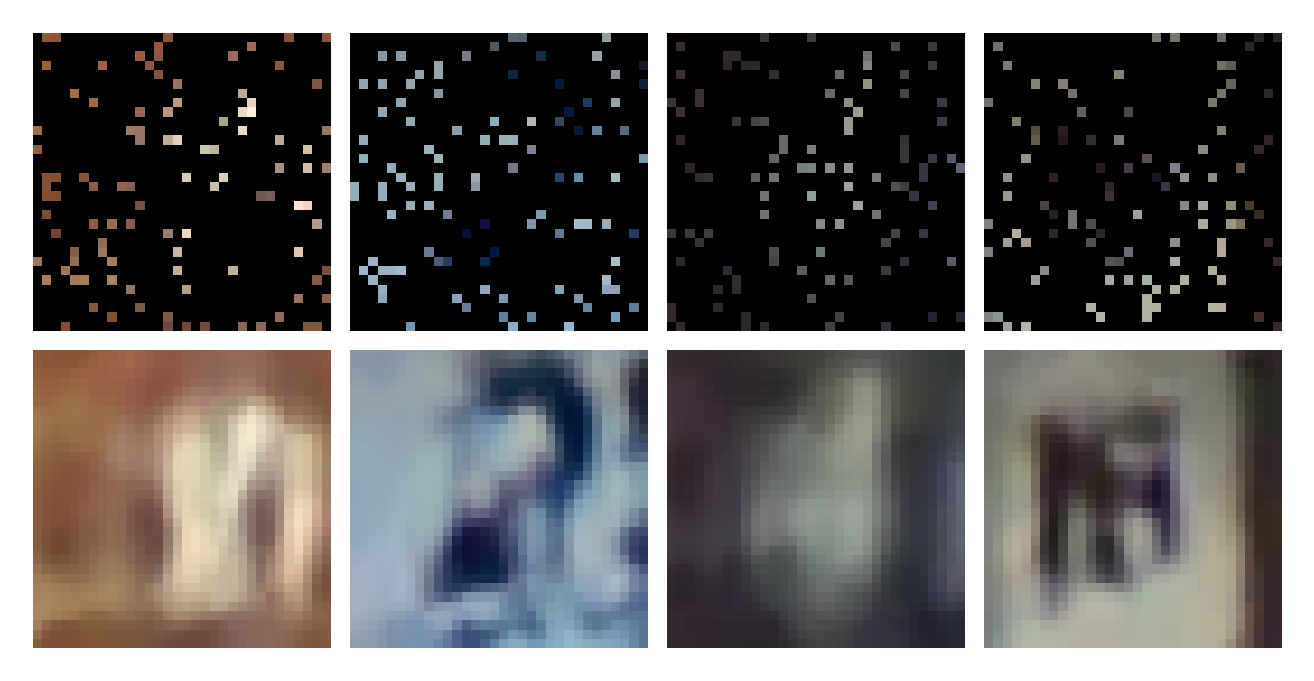

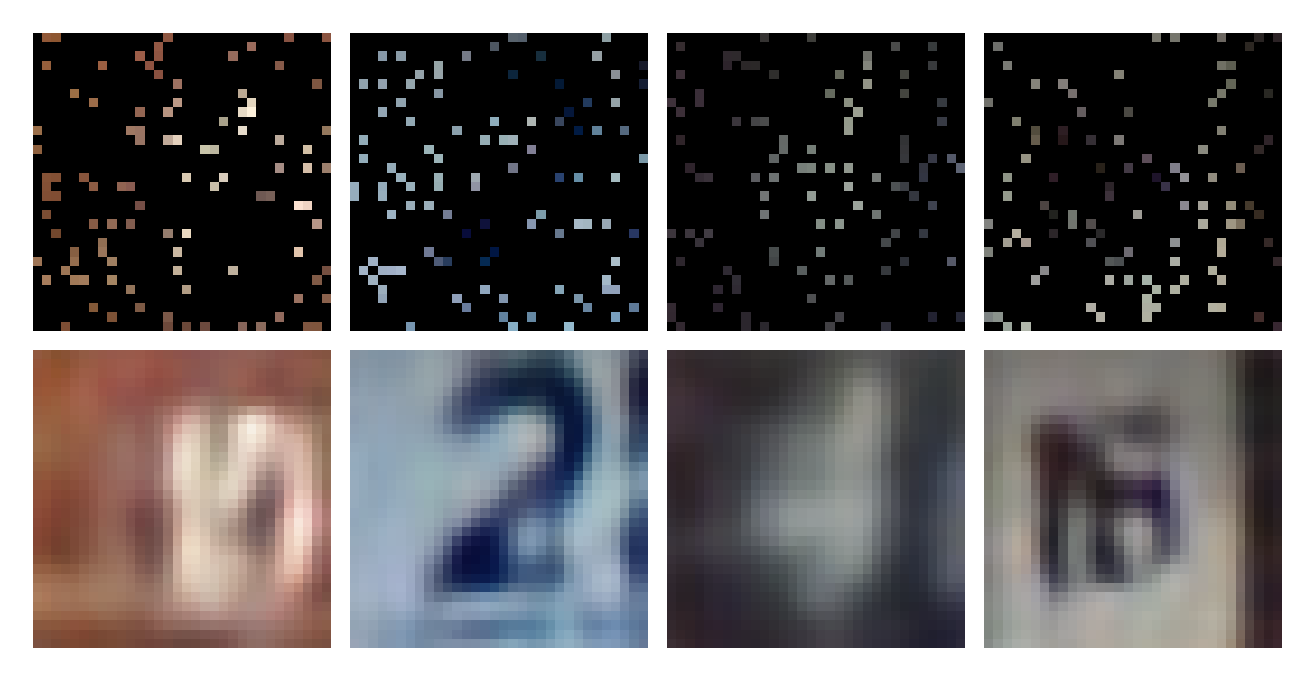

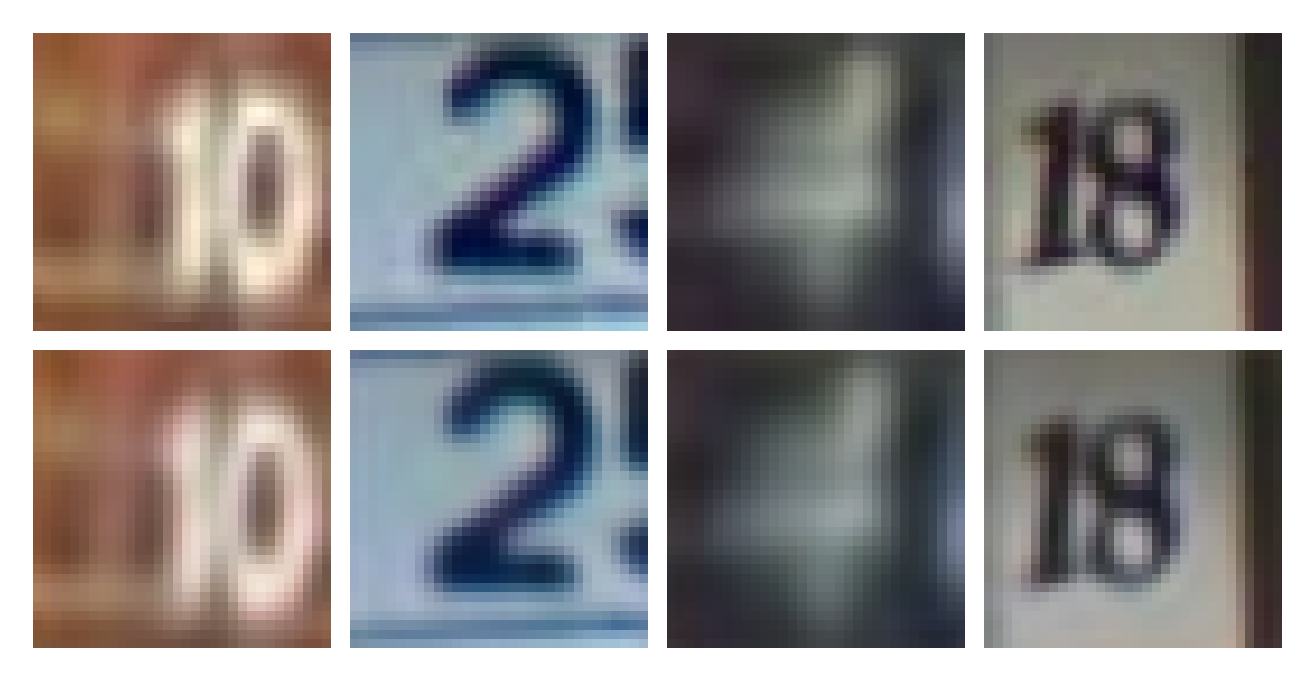

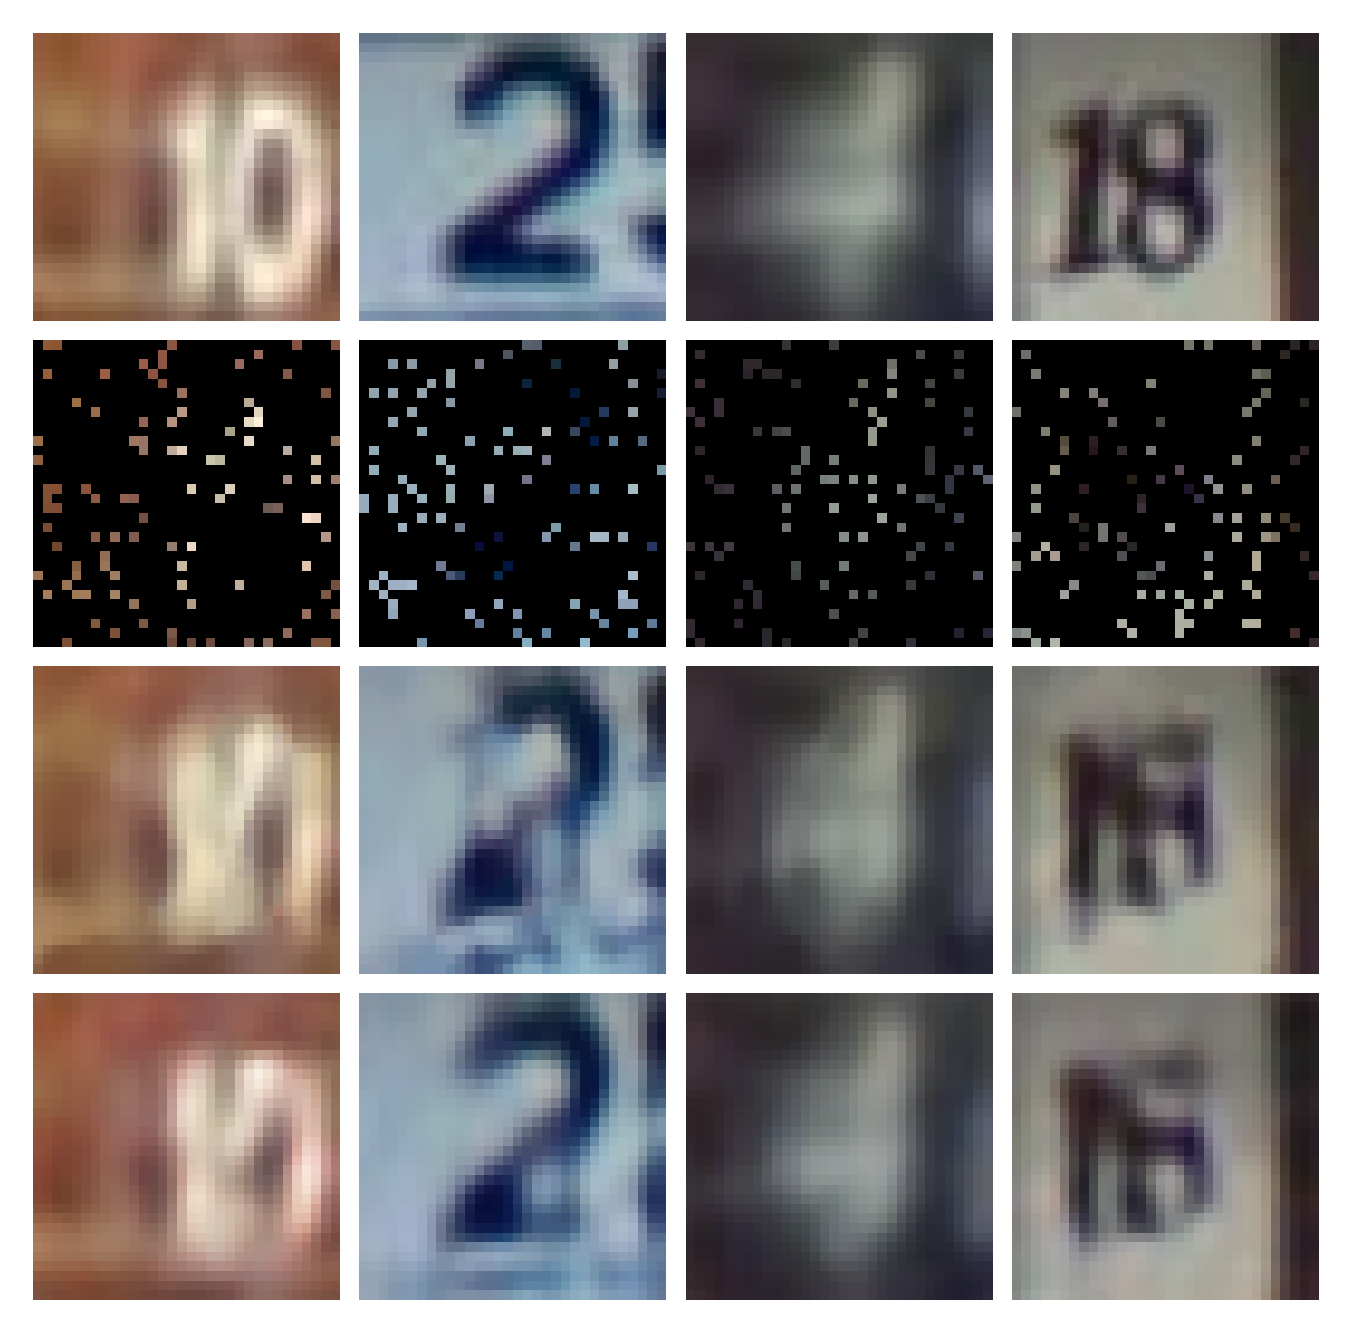

In [165]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

n_nnz=.1

for data_name, (data_train, data_test) in datasets.items():
    if data_name != "svhn":
        continue
    grid_anp = plot_predictions_img_general(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=n_nnz, max_nnz=n_nnz),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_general[data_name+"/"+"anp_simple"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))
    
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for data_name, (data_train, data_test) in datasets.items():
    if data_name != "svhn": 
        continue
    grid_unp = plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=n_nnz, max_nnz=n_nnz),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))
    
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for data_name, (data_train, data_test) in datasets.items():
    if data_name != "svhn": 
        continue
    grid_all = plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=1, max_nnz=1),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))
    
fig, ax = plt.subplots(figsize=(18, 12))
grid=torch.cat((grid_all[:,:32,:], grid_anp, grid_unp[:,36:,:]), dim=1)
ax.imshow(grid.permute(1, 2, 0).numpy())
ax.axis('off')

In [68]:
seed=0

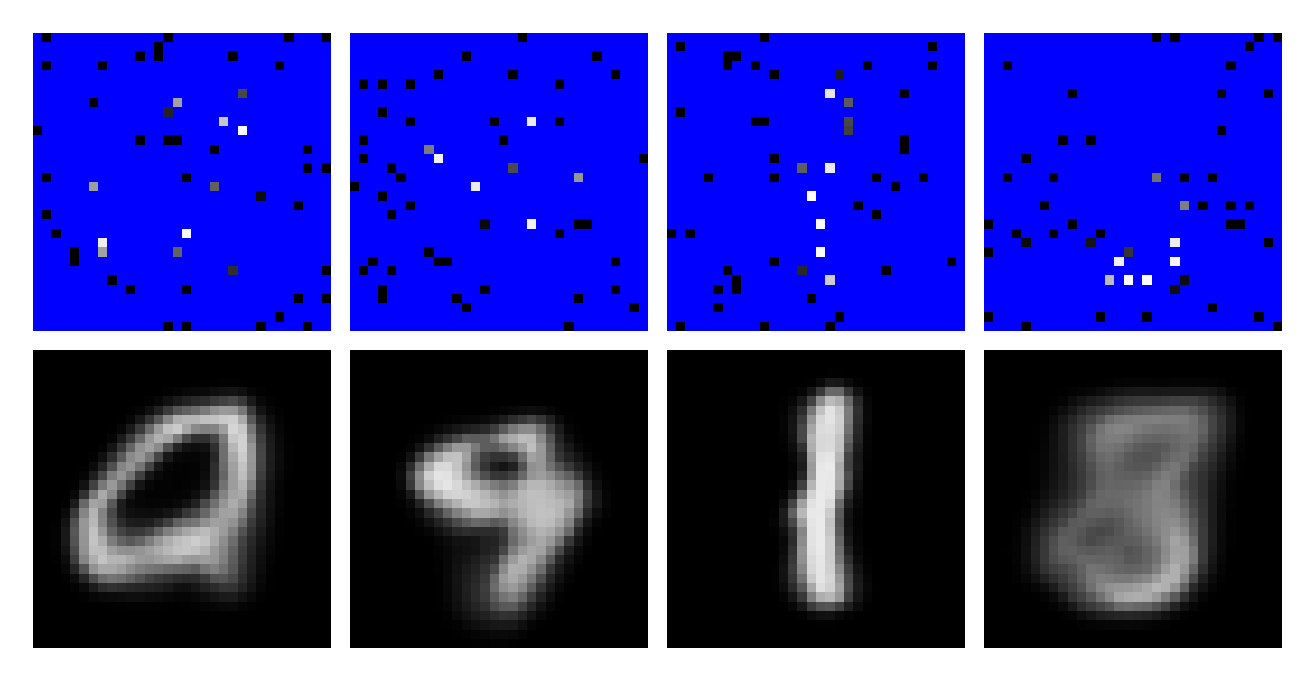

In [72]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for data_name, (data_train, data_test) in datasets.items():
    if data_name != "mnist":
        continue
    grid_anp = plot_predictions_img_general(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_general[data_name+"/"+"anp_simple"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))

tensor(0.1000) tensor(0.1271)


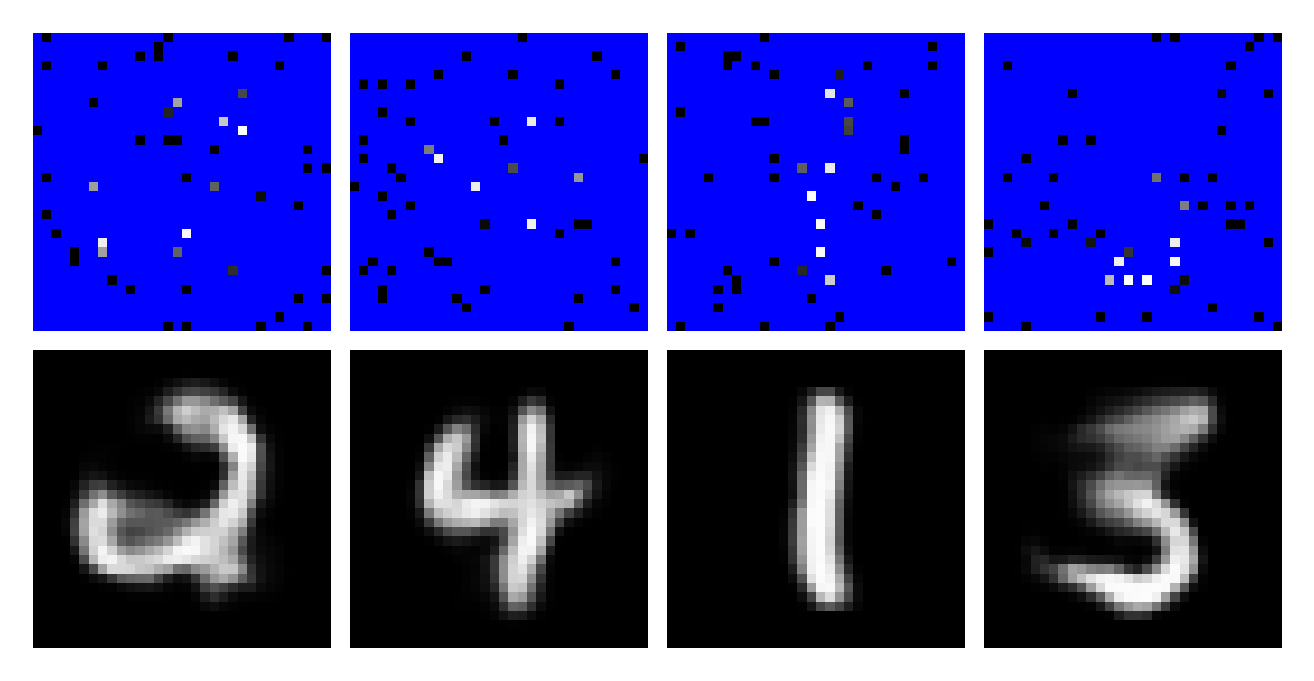

In [110]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for data_name, (data_train, data_test) in datasets.items():
    if data_name != "mnist": 
        continue
    grid_unp = plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))

tensor(0.1000) tensor(0.1001)


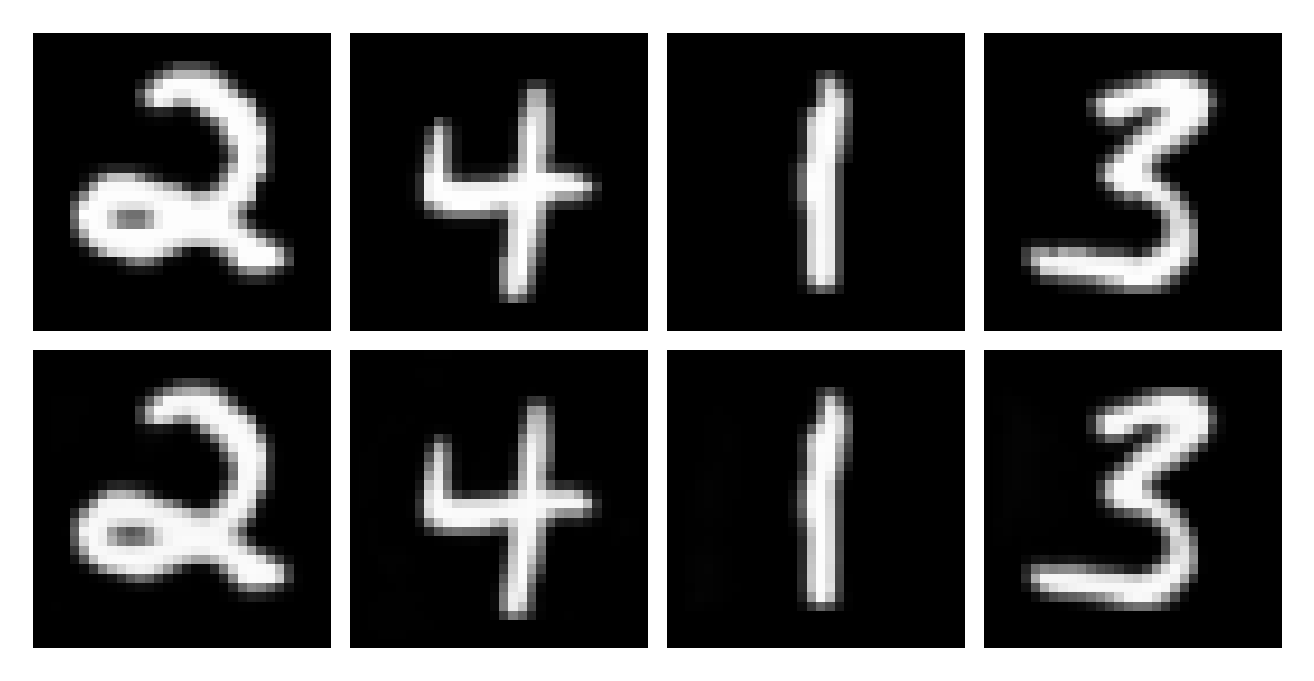

In [74]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for data_name, (data_train, data_test) in datasets.items():
    if data_name != "mnist": 
        continue
    grid_all = plot_predictions_img_grid(data_test, 
                          GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=1, max_nnz=1),
                                             target_masker=no_masker,
                                             is_add_cntxts_to_trgts=False), 
                          data_trainers_grided[data_name+"/"+"transformer_gnp_large_unet"].module_.cpu(), 
                          n_plots=4,
                          figsize=(18, 6))

In [ ]:
, grid_anp, grid_unp[:,34:,:]

(-0.5, 137.5, 135.5, -0.5)

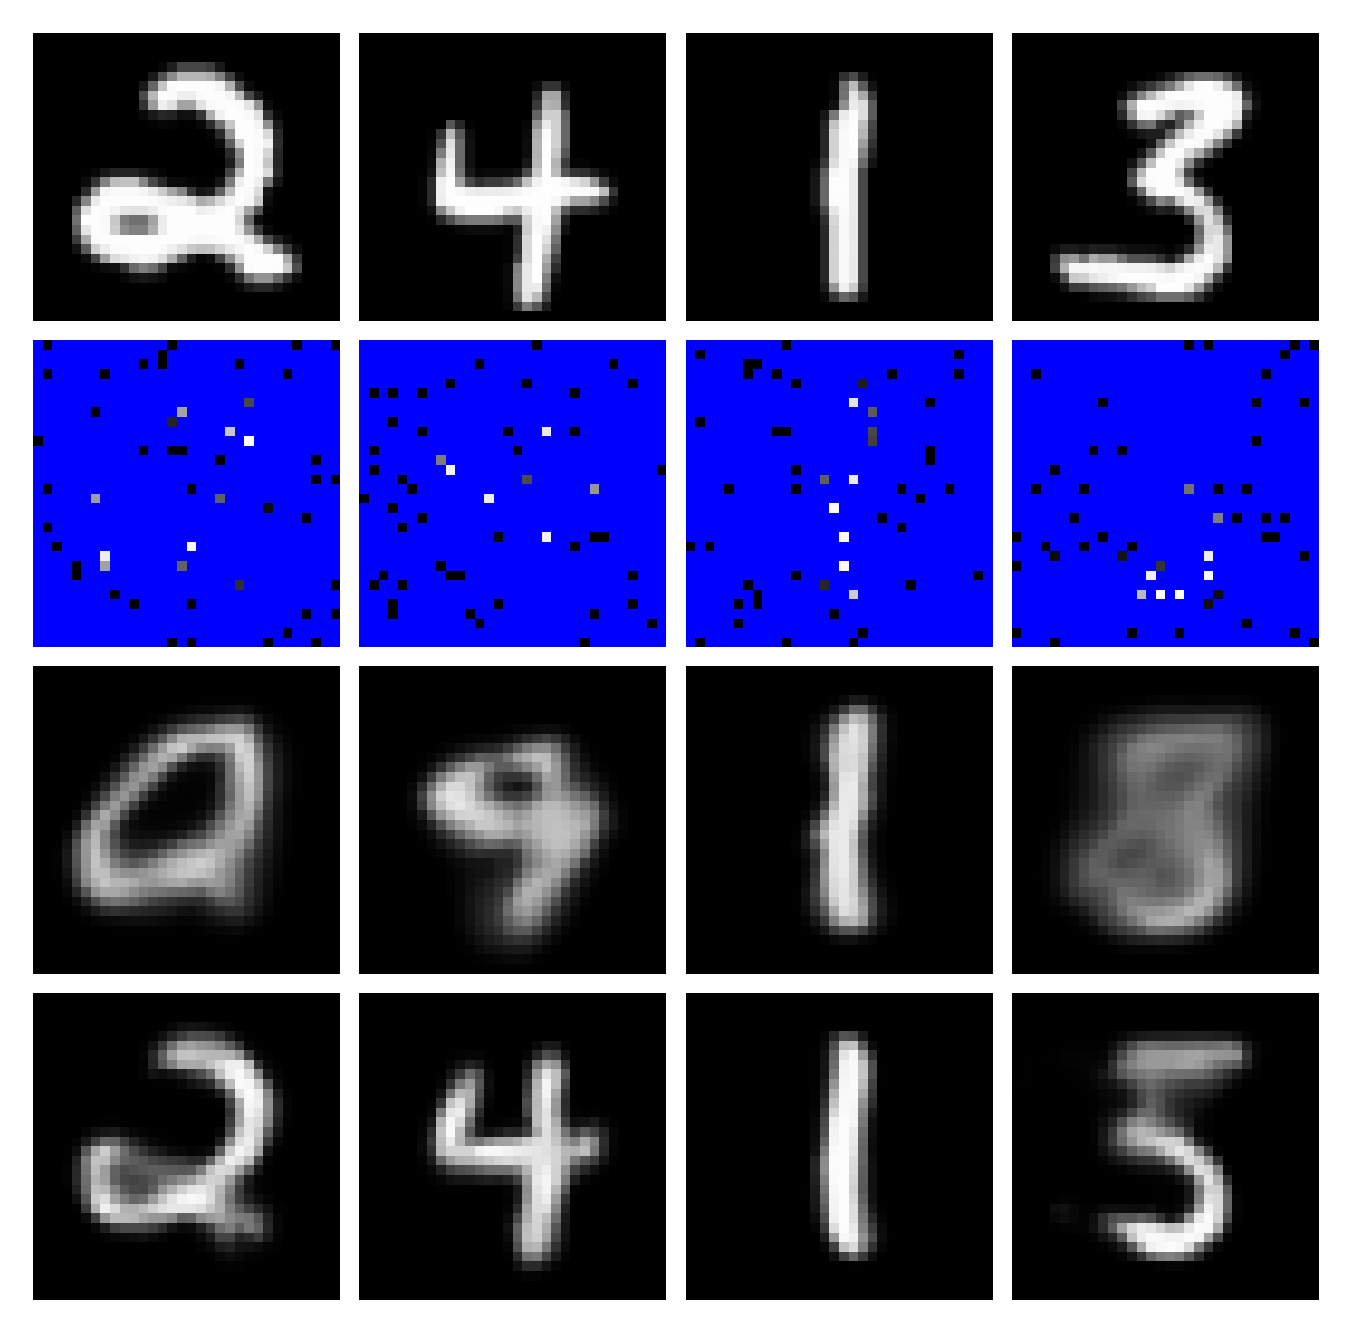

In [93]:
fig, ax = plt.subplots(figsize=(18, 12))
grid=torch.cat((grid_all[:,:32,:], grid_anp, grid_unp[:,36:,:]), dim=1)
ax.imshow(grid.permute(1, 2, 0).numpy())
ax.axis('off')